# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

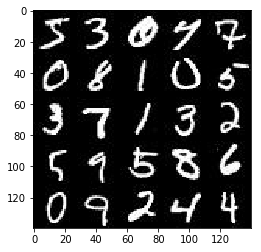

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

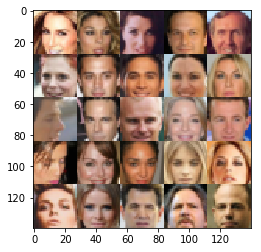

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input =  tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None,z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return (real_input, z_input, learning_rate)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        #14*14*64
        c1 = tf.layers.conv2d(images, 64, kernel_size=5, strides=2, padding='same')
        lrel1 = tf.maximum(alpha * c1, c1)
        
        #7*7*128
        c2 = tf.layers.conv2d(lrel1, 128, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(c2, training=True)
        lrel2 = tf.maximum(alpha * bn1, bn1)
        
        #4*4*256
        c3 = tf.layers.conv2d(lrel2, 256, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c3, training=True)
        lrel3 = tf.maximum(alpha * bn2, bn2)
        #flattening 
        flat = tf.reshape(lrel3, [-1,4*4*256])
        
        #output
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        fc1 = tf.layers.dense(z, 7 * 7 * 1024)
        
        #7*7*1024
        c1 = tf.reshape(fc1, [-1,7,7,1024])
        bn1 = tf.layers.batch_normalization(c1, training=is_train)
        lrel1 = tf.maximum(alpha * bn1 , bn1)
        
        #7*7*512
        c2 = tf.layers.conv2d_transpose(lrel1, 512, kernel_size=5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=is_train)
        lrel2 = tf.maximum(alpha * bn2, bn2)
        kp1 = tf.nn.dropout(lrel2, keep_prob=keep_prob)
        
        #14*14*256
        c3 = tf.layers.conv2d_transpose(kp1, 256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=is_train)
        lrel3 = tf.maximum(alpha * bn3,bn3)
        kp2 = tf.nn.dropout(lrel3, keep_prob=keep_prob)
        
        #14*14*128
        c4 = tf.layers.conv2d_transpose(kp2, 128, kernel_size=5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(c4, training=is_train)
        lrel4 = tf.maximum(alpha * bn4,bn4)
        kp3 = tf.nn.dropout(lrel4, keep_prob=keep_prob)
        
        #28*28*64
        c5 = tf.layers.conv2d_transpose(kp3, 64, kernel_size=5, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(c5, training=is_train)
        lrel5 = tf.maximum(alpha * bn5, bn5)
        kp4 = tf.nn.dropout(lrel5, keep_prob=keep_prob)
        
        #28*28*3
        c6 = tf.layers.conv2d_transpose(kp4,out_channel_dim,kernel_size=5,strides=1,padding='same')
        out = tf.nn.tanh(c6)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real,d_model_real_logits = discriminator(input_real, reuse=False)
    d_model_fake,d_model_fake_logits = discriminator(g_model, reuse=True)
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real_logits,
                                                                         labels=tf.ones_like(d_model_real_logits) *(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                        labels=tf.zeros_like(d_model_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                   labels=tf.ones_like(d_model_fake_logits)))
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
# TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    # getting placeholders
    input_real, input_z,lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # getting losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Getting optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1,(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                if step == 1:
                    print('initial output')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if step % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    train_loss_g = sess.run(g_loss, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    print('Epochs {},batches {}, dis_loss {} , gen_loss {}'.format(epoch_i + 1, step, train_loss_d, train_loss_g))
                if step%100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        saver.save(sess, './generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


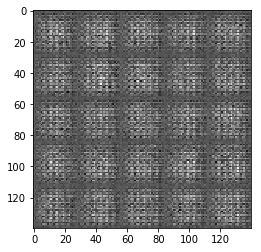

Epochs 1,batches 10, dis_loss 3.6840574741363525 , gen_loss 0.08649010956287384
Epochs 1,batches 20, dis_loss 0.7177792191505432 , gen_loss 5.5692877769470215
Epochs 1,batches 30, dis_loss 1.6682275533676147 , gen_loss 3.309096336364746
Epochs 1,batches 40, dis_loss 1.678678035736084 , gen_loss 0.44165387749671936
Epochs 1,batches 50, dis_loss 1.7505323886871338 , gen_loss 0.7334409952163696
Epochs 1,batches 60, dis_loss 1.4669225215911865 , gen_loss 0.5059026479721069
Epochs 1,batches 70, dis_loss 1.5000700950622559 , gen_loss 0.7145023345947266
Epochs 1,batches 80, dis_loss 1.8271228075027466 , gen_loss 0.4449951946735382
Epochs 1,batches 90, dis_loss 1.5542618036270142 , gen_loss 0.47854429483413696
Epochs 1,batches 100, dis_loss 1.911962628364563 , gen_loss 0.46798840165138245


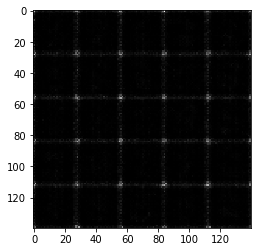

Epochs 1,batches 110, dis_loss 1.510006308555603 , gen_loss 0.6700423955917358
Epochs 1,batches 120, dis_loss 1.9681364297866821 , gen_loss 0.35324180126190186
Epochs 1,batches 130, dis_loss 1.6615278720855713 , gen_loss 0.7284618616104126
Epochs 1,batches 140, dis_loss 1.405447006225586 , gen_loss 0.7023084163665771
Epochs 1,batches 150, dis_loss 1.4429030418395996 , gen_loss 0.7397948503494263
Epochs 1,batches 160, dis_loss 1.649629831314087 , gen_loss 0.883063554763794
Epochs 1,batches 170, dis_loss 1.6113393306732178 , gen_loss 0.820909321308136
Epochs 1,batches 180, dis_loss 1.5831940174102783 , gen_loss 0.6917444467544556
Epochs 1,batches 190, dis_loss 1.6465693712234497 , gen_loss 0.9952195882797241
Epochs 1,batches 200, dis_loss 1.7171447277069092 , gen_loss 0.38000255823135376


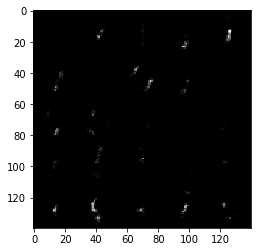

Epochs 1,batches 210, dis_loss 1.388052225112915 , gen_loss 0.7827967405319214
Epochs 1,batches 220, dis_loss 1.3040993213653564 , gen_loss 0.9306777119636536
Epochs 1,batches 230, dis_loss 1.4210432767868042 , gen_loss 0.6310226321220398
Epochs 1,batches 240, dis_loss 1.503945231437683 , gen_loss 0.5651747584342957
Epochs 1,batches 250, dis_loss 1.6900023221969604 , gen_loss 0.396446168422699
Epochs 1,batches 260, dis_loss 1.5822718143463135 , gen_loss 0.6228428483009338
Epochs 1,batches 270, dis_loss 1.3169591426849365 , gen_loss 0.6833930015563965
Epochs 1,batches 280, dis_loss 1.6329655647277832 , gen_loss 0.5864217281341553
Epochs 1,batches 290, dis_loss 1.2138628959655762 , gen_loss 0.8456442356109619
Epochs 1,batches 300, dis_loss 1.2582327127456665 , gen_loss 0.7559340000152588


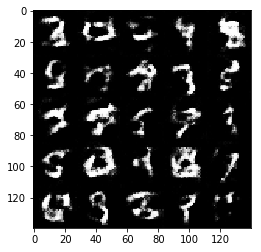

Epochs 1,batches 310, dis_loss 1.2712793350219727 , gen_loss 0.9670124650001526
Epochs 1,batches 320, dis_loss 1.3818433284759521 , gen_loss 0.8270220756530762
Epochs 1,batches 330, dis_loss 1.1686620712280273 , gen_loss 0.8541104793548584
Epochs 1,batches 340, dis_loss 1.6319142580032349 , gen_loss 0.5742381811141968
Epochs 1,batches 350, dis_loss 1.7278358936309814 , gen_loss 0.46696406602859497
Epochs 1,batches 360, dis_loss 1.2448763847351074 , gen_loss 1.0280396938323975
Epochs 1,batches 370, dis_loss 1.5044455528259277 , gen_loss 0.517202615737915
Epochs 1,batches 380, dis_loss 1.3031282424926758 , gen_loss 0.9023346304893494
Epochs 1,batches 390, dis_loss 1.3001775741577148 , gen_loss 1.0336873531341553
Epochs 1,batches 400, dis_loss 1.4379265308380127 , gen_loss 0.5697842836380005


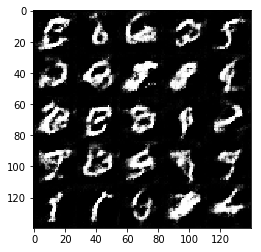

Epochs 1,batches 410, dis_loss 1.4448901414871216 , gen_loss 1.0381598472595215
Epochs 1,batches 420, dis_loss 1.613342046737671 , gen_loss 0.9245716333389282
Epochs 1,batches 430, dis_loss 1.4357225894927979 , gen_loss 0.8712172508239746
Epochs 1,batches 440, dis_loss 1.3362171649932861 , gen_loss 0.6249340772628784
Epochs 1,batches 450, dis_loss 1.3082168102264404 , gen_loss 1.0478038787841797
Epochs 1,batches 460, dis_loss 1.3779536485671997 , gen_loss 0.5963557958602905
Epochs 1,batches 470, dis_loss 1.6307326555252075 , gen_loss 0.4520729184150696
Epochs 1,batches 480, dis_loss 1.4661628007888794 , gen_loss 0.512679398059845
Epochs 1,batches 490, dis_loss 1.7296468019485474 , gen_loss 0.3989819288253784
Epochs 1,batches 500, dis_loss 1.535520076751709 , gen_loss 0.4967738389968872


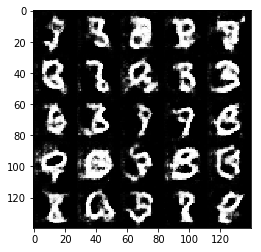

Epochs 1,batches 510, dis_loss 1.4869606494903564 , gen_loss 0.8999660015106201
Epochs 1,batches 520, dis_loss 1.4998524188995361 , gen_loss 0.6043727397918701
Epochs 1,batches 530, dis_loss 1.3487513065338135 , gen_loss 0.6538241505622864
Epochs 1,batches 540, dis_loss 1.4700517654418945 , gen_loss 0.5593936443328857
Epochs 1,batches 550, dis_loss 1.4203110933303833 , gen_loss 0.6079496145248413
Epochs 1,batches 560, dis_loss 1.2775628566741943 , gen_loss 0.7600895166397095
Epochs 1,batches 570, dis_loss 1.3759028911590576 , gen_loss 0.5083348751068115
Epochs 1,batches 580, dis_loss 1.340597152709961 , gen_loss 0.6460551619529724
Epochs 1,batches 590, dis_loss 1.463867425918579 , gen_loss 0.672920823097229
Epochs 1,batches 600, dis_loss 1.4218711853027344 , gen_loss 0.6343544721603394


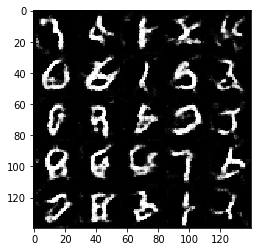

Epochs 1,batches 610, dis_loss 1.5138561725616455 , gen_loss 0.4791766405105591
Epochs 1,batches 620, dis_loss 1.326878547668457 , gen_loss 0.6443545818328857
Epochs 1,batches 630, dis_loss 1.3343145847320557 , gen_loss 0.5879930257797241
Epochs 1,batches 640, dis_loss 1.326563835144043 , gen_loss 0.6772770881652832
Epochs 1,batches 650, dis_loss 1.4254388809204102 , gen_loss 0.6351495981216431
Epochs 1,batches 660, dis_loss 1.4212827682495117 , gen_loss 0.5638248920440674
Epochs 1,batches 670, dis_loss 1.323948860168457 , gen_loss 0.595052182674408
Epochs 1,batches 680, dis_loss 1.4486382007598877 , gen_loss 0.6972050666809082
Epochs 1,batches 690, dis_loss 1.5456125736236572 , gen_loss 0.5202124714851379
Epochs 1,batches 700, dis_loss 1.5985603332519531 , gen_loss 0.4018949270248413


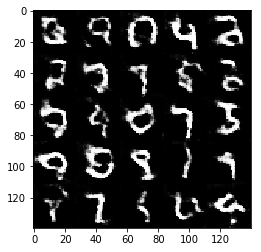

Epochs 1,batches 710, dis_loss 1.2546494007110596 , gen_loss 0.7271916270256042
Epochs 1,batches 720, dis_loss 1.3778541088104248 , gen_loss 0.7297296524047852
Epochs 1,batches 730, dis_loss 1.2945609092712402 , gen_loss 1.3119103908538818
Epochs 1,batches 740, dis_loss 1.2747372388839722 , gen_loss 1.2099120616912842
Epochs 1,batches 750, dis_loss 1.4569181203842163 , gen_loss 1.2097420692443848
Epochs 1,batches 760, dis_loss 1.380273699760437 , gen_loss 0.5327532887458801
Epochs 1,batches 770, dis_loss 1.254940152168274 , gen_loss 0.8486239910125732
Epochs 1,batches 780, dis_loss 1.1604831218719482 , gen_loss 1.026098608970642
Epochs 1,batches 790, dis_loss 1.5395365953445435 , gen_loss 0.502629816532135
Epochs 1,batches 800, dis_loss 1.1143466234207153 , gen_loss 1.0420987606048584


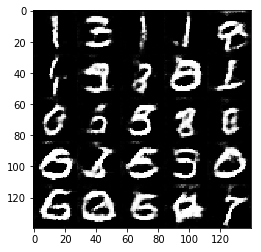

Epochs 1,batches 810, dis_loss 1.3792328834533691 , gen_loss 0.562641978263855
Epochs 1,batches 820, dis_loss 1.3498295545578003 , gen_loss 0.9757261276245117
Epochs 1,batches 830, dis_loss 1.2417843341827393 , gen_loss 0.9352013468742371
Epochs 1,batches 840, dis_loss 1.4557863473892212 , gen_loss 1.019014596939087
Epochs 1,batches 850, dis_loss 1.3565747737884521 , gen_loss 0.644133448600769
Epochs 1,batches 860, dis_loss 1.4356884956359863 , gen_loss 0.7252612113952637
Epochs 1,batches 870, dis_loss 1.6446319818496704 , gen_loss 1.1029372215270996
Epochs 1,batches 880, dis_loss 1.2266700267791748 , gen_loss 1.2471362352371216
Epochs 1,batches 890, dis_loss 1.4502309560775757 , gen_loss 0.4928045868873596
Epochs 1,batches 900, dis_loss 1.4414550065994263 , gen_loss 0.5592774152755737


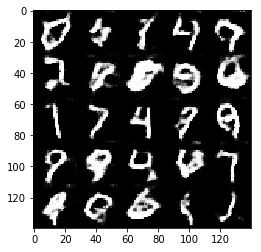

Epochs 1,batches 910, dis_loss 1.2347397804260254 , gen_loss 0.9830433130264282
Epochs 1,batches 920, dis_loss 1.2672982215881348 , gen_loss 0.9263167977333069
Epochs 1,batches 930, dis_loss 1.2129051685333252 , gen_loss 0.6310878396034241
Epochs 1,batches 940, dis_loss 1.8642123937606812 , gen_loss 2.370976448059082
Epochs 1,batches 950, dis_loss 1.2960106134414673 , gen_loss 1.26082181930542
Epochs 1,batches 960, dis_loss 1.5370864868164062 , gen_loss 0.45856356620788574
Epochs 1,batches 970, dis_loss 1.1857236623764038 , gen_loss 0.6814389824867249
Epochs 1,batches 980, dis_loss 1.437959909439087 , gen_loss 0.4931619465351105
Epochs 1,batches 990, dis_loss 1.238940954208374 , gen_loss 0.8144326210021973
Epochs 1,batches 1000, dis_loss 1.124281883239746 , gen_loss 0.7167677283287048


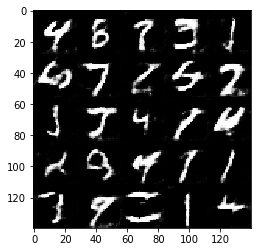

Epochs 1,batches 1010, dis_loss 1.1706172227859497 , gen_loss 0.9366971254348755
Epochs 1,batches 1020, dis_loss 1.52386474609375 , gen_loss 0.5001693367958069
Epochs 1,batches 1030, dis_loss 1.349064826965332 , gen_loss 0.5779158473014832
Epochs 1,batches 1040, dis_loss 1.1845383644104004 , gen_loss 0.9735567569732666
Epochs 1,batches 1050, dis_loss 1.2781143188476562 , gen_loss 0.7297853231430054
Epochs 1,batches 1060, dis_loss 1.183273434638977 , gen_loss 0.7458224296569824
Epochs 1,batches 1070, dis_loss 1.1061125993728638 , gen_loss 1.1706639528274536
Epochs 1,batches 1080, dis_loss 1.320809006690979 , gen_loss 0.6817417144775391
Epochs 1,batches 1090, dis_loss 1.2214595079421997 , gen_loss 0.9966102838516235
Epochs 1,batches 1100, dis_loss 1.26185142993927 , gen_loss 0.63133704662323


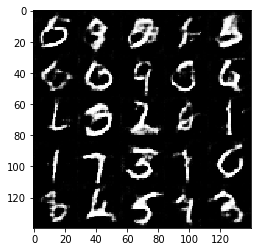

Epochs 1,batches 1110, dis_loss 1.3938226699829102 , gen_loss 0.5528442859649658
Epochs 1,batches 1120, dis_loss 1.2386419773101807 , gen_loss 0.7390468120574951
Epochs 1,batches 1130, dis_loss 1.185583233833313 , gen_loss 0.9059789180755615
Epochs 1,batches 1140, dis_loss 1.3218090534210205 , gen_loss 0.9358399510383606
Epochs 1,batches 1150, dis_loss 1.2472511529922485 , gen_loss 0.7910730242729187
Epochs 1,batches 1160, dis_loss 1.0815777778625488 , gen_loss 0.975969135761261
Epochs 1,batches 1170, dis_loss 1.5512343645095825 , gen_loss 0.4056142568588257
Epochs 1,batches 1180, dis_loss 1.19086754322052 , gen_loss 0.8704327344894409
Epochs 1,batches 1190, dis_loss 1.2113659381866455 , gen_loss 1.265538215637207
Epochs 1,batches 1200, dis_loss 1.2627266645431519 , gen_loss 1.0608062744140625


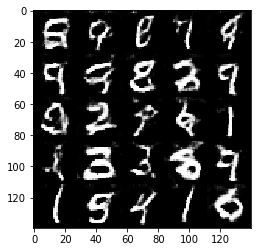

Epochs 1,batches 1210, dis_loss 1.1389656066894531 , gen_loss 0.9802957773208618
Epochs 1,batches 1220, dis_loss 1.479572057723999 , gen_loss 0.47426271438598633
Epochs 1,batches 1230, dis_loss 1.074100375175476 , gen_loss 1.16459321975708
Epochs 1,batches 1240, dis_loss 1.3359185457229614 , gen_loss 1.3708875179290771
Epochs 1,batches 1250, dis_loss 1.4298346042633057 , gen_loss 0.4905398488044739
Epochs 1,batches 1260, dis_loss 1.420969009399414 , gen_loss 0.4873387813568115
Epochs 1,batches 1270, dis_loss 1.3221757411956787 , gen_loss 1.2684862613677979
Epochs 1,batches 1280, dis_loss 1.4644849300384521 , gen_loss 0.5410163402557373
Epochs 1,batches 1290, dis_loss 1.3910341262817383 , gen_loss 0.5969967842102051
Epochs 1,batches 1300, dis_loss 1.3220133781433105 , gen_loss 0.5832235217094421


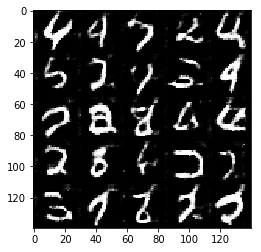

Epochs 1,batches 1310, dis_loss 1.3827476501464844 , gen_loss 0.6058710217475891
Epochs 1,batches 1320, dis_loss 1.2364293336868286 , gen_loss 0.9079352617263794
Epochs 1,batches 1330, dis_loss 1.1389509439468384 , gen_loss 0.8159005641937256
Epochs 1,batches 1340, dis_loss 1.3991804122924805 , gen_loss 0.49677470326423645
Epochs 1,batches 1350, dis_loss 1.3509618043899536 , gen_loss 0.6120110154151917
Epochs 1,batches 1360, dis_loss 1.2400407791137695 , gen_loss 0.6271318197250366
Epochs 1,batches 1370, dis_loss 1.321150302886963 , gen_loss 0.8438036441802979
Epochs 1,batches 1380, dis_loss 1.2919055223464966 , gen_loss 0.7888001203536987
Epochs 1,batches 1390, dis_loss 1.1666017770767212 , gen_loss 0.9467544555664062
Epochs 1,batches 1400, dis_loss 1.3607251644134521 , gen_loss 0.5872790813446045


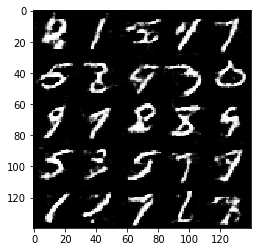

Epochs 1,batches 1410, dis_loss 0.9384084939956665 , gen_loss 1.1128370761871338
Epochs 1,batches 1420, dis_loss 1.362316608428955 , gen_loss 0.9041197896003723
Epochs 1,batches 1430, dis_loss 1.182455062866211 , gen_loss 0.7274669408798218
Epochs 1,batches 1440, dis_loss 1.4199646711349487 , gen_loss 0.5832892656326294
Epochs 1,batches 1450, dis_loss 1.4138753414154053 , gen_loss 0.5134329199790955
Epochs 1,batches 1460, dis_loss 1.1606059074401855 , gen_loss 0.9466731548309326
Epochs 1,batches 1470, dis_loss 1.0921506881713867 , gen_loss 1.0911537408828735
Epochs 1,batches 1480, dis_loss 1.443210482597351 , gen_loss 0.5839592218399048
Epochs 1,batches 1490, dis_loss 1.78082275390625 , gen_loss 0.3113669753074646
Epochs 1,batches 1500, dis_loss 1.170708179473877 , gen_loss 1.2596933841705322


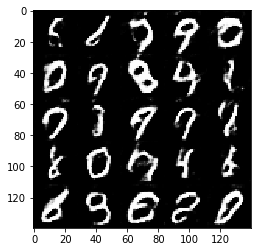

Epochs 1,batches 1510, dis_loss 1.3151209354400635 , gen_loss 0.8051530122756958
Epochs 1,batches 1520, dis_loss 1.5848644971847534 , gen_loss 0.39021408557891846
Epochs 1,batches 1530, dis_loss 1.4103224277496338 , gen_loss 0.6412379145622253
Epochs 1,batches 1540, dis_loss 1.233349084854126 , gen_loss 0.6668814420700073
Epochs 1,batches 1550, dis_loss 1.6334195137023926 , gen_loss 1.6194496154785156
Epochs 1,batches 1560, dis_loss 1.494325876235962 , gen_loss 0.866621196269989
Epochs 1,batches 1570, dis_loss 1.3110020160675049 , gen_loss 0.7662315964698792
Epochs 1,batches 1580, dis_loss 1.307682991027832 , gen_loss 0.9680029153823853
Epochs 1,batches 1590, dis_loss 1.373828411102295 , gen_loss 0.848760187625885
Epochs 1,batches 1600, dis_loss 1.1826815605163574 , gen_loss 0.7732231616973877


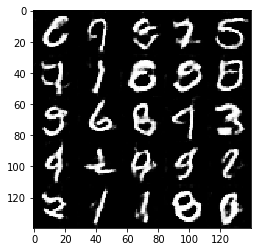

Epochs 1,batches 1610, dis_loss 1.0225613117218018 , gen_loss 0.8518576622009277
Epochs 1,batches 1620, dis_loss 1.1321831941604614 , gen_loss 0.8219708800315857
Epochs 1,batches 1630, dis_loss 0.9356386661529541 , gen_loss 1.4181678295135498
Epochs 1,batches 1640, dis_loss 1.2311537265777588 , gen_loss 0.6601644158363342
Epochs 1,batches 1650, dis_loss 1.265372633934021 , gen_loss 1.0681164264678955
Epochs 1,batches 1660, dis_loss 1.2801190614700317 , gen_loss 0.6069458723068237
Epochs 1,batches 1670, dis_loss 1.0421041250228882 , gen_loss 0.9460973143577576
Epochs 1,batches 1680, dis_loss 1.254774808883667 , gen_loss 0.6645370721817017
Epochs 1,batches 1690, dis_loss 1.144322395324707 , gen_loss 0.9546992182731628
Epochs 1,batches 1700, dis_loss 1.3169649839401245 , gen_loss 0.6197566390037537


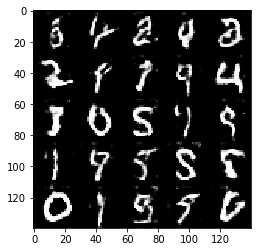

Epochs 1,batches 1710, dis_loss 1.1798204183578491 , gen_loss 0.8281723260879517
Epochs 1,batches 1720, dis_loss 1.0637751817703247 , gen_loss 0.9384550452232361
Epochs 1,batches 1730, dis_loss 1.3901989459991455 , gen_loss 0.5793749094009399
Epochs 1,batches 1740, dis_loss 1.1766571998596191 , gen_loss 1.0234856605529785
Epochs 1,batches 1750, dis_loss 1.144637107849121 , gen_loss 0.7740178108215332
Epochs 1,batches 1760, dis_loss 1.2288451194763184 , gen_loss 1.0605168342590332
Epochs 1,batches 1770, dis_loss 1.0720269680023193 , gen_loss 0.8954284191131592
Epochs 1,batches 1780, dis_loss 1.4376939535140991 , gen_loss 0.48035597801208496
Epochs 1,batches 1790, dis_loss 0.9791791439056396 , gen_loss 1.6140670776367188
Epochs 1,batches 1800, dis_loss 1.204468846321106 , gen_loss 0.6097002029418945


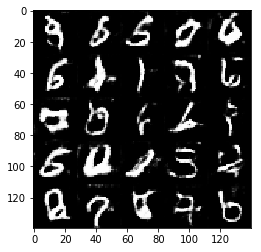

Epochs 1,batches 1810, dis_loss 1.1412668228149414 , gen_loss 0.6980004906654358
Epochs 1,batches 1820, dis_loss 1.0968886613845825 , gen_loss 0.8832530975341797
Epochs 1,batches 1830, dis_loss 1.1404743194580078 , gen_loss 1.0130895376205444
Epochs 1,batches 1840, dis_loss 1.3387889862060547 , gen_loss 0.5843942165374756
Epochs 1,batches 1850, dis_loss 1.0272343158721924 , gen_loss 0.933672308921814
Epochs 1,batches 1860, dis_loss 1.3834840059280396 , gen_loss 1.2345927953720093
Epochs 1,batches 1870, dis_loss 1.1770200729370117 , gen_loss 0.9977577328681946
Epochs 1,batches 1880, dis_loss 1.4334330558776855 , gen_loss 0.7154711484909058
Epochs 1,batches 1890, dis_loss 1.1609845161437988 , gen_loss 1.3507834672927856
Epochs 1,batches 1900, dis_loss 1.164454698562622 , gen_loss 1.1584326028823853


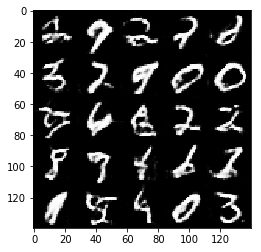

Epochs 1,batches 1910, dis_loss 1.2088088989257812 , gen_loss 0.6909693479537964
Epochs 1,batches 1920, dis_loss 0.98161780834198 , gen_loss 0.8633368015289307
Epochs 1,batches 1930, dis_loss 1.13480544090271 , gen_loss 0.9014278650283813
Epochs 1,batches 1940, dis_loss 1.4340343475341797 , gen_loss 0.4424215853214264
Epochs 1,batches 1950, dis_loss 1.0167561769485474 , gen_loss 1.4353021383285522
Epochs 1,batches 1960, dis_loss 0.9253029227256775 , gen_loss 1.032978892326355
Epochs 1,batches 1970, dis_loss 1.1612119674682617 , gen_loss 0.7860357761383057
Epochs 1,batches 1980, dis_loss 1.0479540824890137 , gen_loss 0.8547877073287964
Epochs 1,batches 1990, dis_loss 1.1731088161468506 , gen_loss 0.982275128364563
Epochs 1,batches 2000, dis_loss 1.1657434701919556 , gen_loss 1.1811647415161133


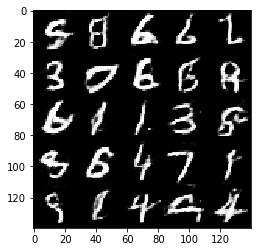

Epochs 1,batches 2010, dis_loss 1.0848004817962646 , gen_loss 0.9684255123138428
Epochs 1,batches 2020, dis_loss 1.0649454593658447 , gen_loss 1.0397000312805176
Epochs 1,batches 2030, dis_loss 1.284729242324829 , gen_loss 0.5979295969009399
Epochs 1,batches 2040, dis_loss 1.2881615161895752 , gen_loss 0.8610034584999084
Epochs 1,batches 2050, dis_loss 1.2892656326293945 , gen_loss 1.0099267959594727
Epochs 1,batches 2060, dis_loss 1.2682141065597534 , gen_loss 0.7538472414016724
Epochs 1,batches 2070, dis_loss 1.1234142780303955 , gen_loss 0.8197939395904541
Epochs 1,batches 2080, dis_loss 1.4276649951934814 , gen_loss 0.6009913682937622
Epochs 1,batches 2090, dis_loss 1.5013998746871948 , gen_loss 0.49453088641166687
Epochs 1,batches 2100, dis_loss 0.999735951423645 , gen_loss 1.1316417455673218


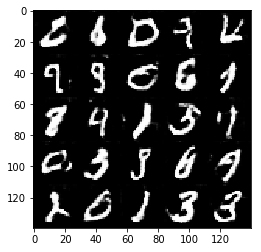

Epochs 1,batches 2110, dis_loss 1.0660955905914307 , gen_loss 0.9763780832290649
Epochs 1,batches 2120, dis_loss 1.5549557209014893 , gen_loss 2.148634672164917
Epochs 1,batches 2130, dis_loss 1.0806567668914795 , gen_loss 1.0879504680633545
Epochs 1,batches 2140, dis_loss 1.0952011346817017 , gen_loss 0.9201476573944092
Epochs 1,batches 2150, dis_loss 1.0555018186569214 , gen_loss 0.7991019487380981
Epochs 1,batches 2160, dis_loss 1.1202783584594727 , gen_loss 0.7875601053237915
Epochs 1,batches 2170, dis_loss 0.9810315370559692 , gen_loss 1.9159557819366455
Epochs 1,batches 2180, dis_loss 1.074275255203247 , gen_loss 0.766687273979187
Epochs 1,batches 2190, dis_loss 1.3640064001083374 , gen_loss 2.121739149093628
Epochs 1,batches 2200, dis_loss 1.042892336845398 , gen_loss 0.8707554936408997


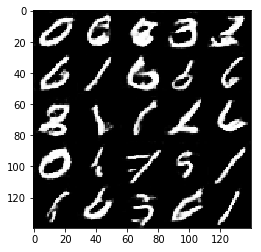

Epochs 1,batches 2210, dis_loss 0.8286817073822021 , gen_loss 1.2543009519577026
Epochs 1,batches 2220, dis_loss 1.157974362373352 , gen_loss 0.70633864402771
Epochs 1,batches 2230, dis_loss 1.1194267272949219 , gen_loss 1.1823480129241943
Epochs 1,batches 2240, dis_loss 1.4115673303604126 , gen_loss 0.4263651371002197
Epochs 1,batches 2250, dis_loss 0.9014621376991272 , gen_loss 1.0905799865722656
Epochs 1,batches 2260, dis_loss 1.120680809020996 , gen_loss 0.6709038019180298
Epochs 1,batches 2270, dis_loss 1.3393895626068115 , gen_loss 0.6252620816230774
Epochs 1,batches 2280, dis_loss 1.0872019529342651 , gen_loss 1.315674066543579
Epochs 1,batches 2290, dis_loss 1.107370138168335 , gen_loss 1.3259303569793701
Epochs 1,batches 2300, dis_loss 1.8736729621887207 , gen_loss 0.3096938729286194


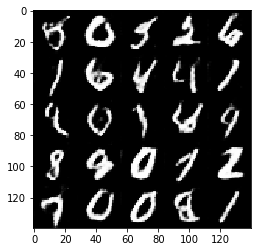

Epochs 1,batches 2310, dis_loss 0.9886894822120667 , gen_loss 1.1879371404647827
Epochs 1,batches 2320, dis_loss 0.9647995233535767 , gen_loss 1.2094662189483643
Epochs 1,batches 2330, dis_loss 1.2138372659683228 , gen_loss 0.7504377961158752
Epochs 1,batches 2340, dis_loss 1.165532112121582 , gen_loss 1.3127729892730713
Epochs 1,batches 2350, dis_loss 1.0534758567810059 , gen_loss 0.8967662453651428
Epochs 1,batches 2360, dis_loss 1.0218356847763062 , gen_loss 0.9516926407814026
Epochs 1,batches 2370, dis_loss 0.9653023481369019 , gen_loss 1.1560821533203125
Epochs 1,batches 2380, dis_loss 1.264694333076477 , gen_loss 0.5923620462417603
Epochs 1,batches 2390, dis_loss 1.2826335430145264 , gen_loss 1.360412359237671
Epochs 1,batches 2400, dis_loss 0.9473196268081665 , gen_loss 1.6919499635696411


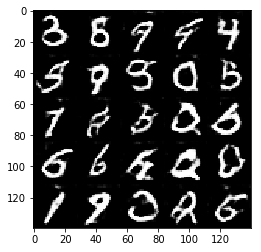

Epochs 1,batches 2410, dis_loss 0.9880780577659607 , gen_loss 0.8939392566680908
Epochs 1,batches 2420, dis_loss 0.9140494465827942 , gen_loss 1.1055710315704346
Epochs 1,batches 2430, dis_loss 1.3820855617523193 , gen_loss 0.6318472623825073
Epochs 1,batches 2440, dis_loss 1.1144113540649414 , gen_loss 1.3097164630889893
Epochs 1,batches 2450, dis_loss 1.1180524826049805 , gen_loss 2.0640575885772705
Epochs 1,batches 2460, dis_loss 1.0824346542358398 , gen_loss 0.8883812427520752
Epochs 1,batches 2470, dis_loss 1.1898106336593628 , gen_loss 0.6853207349777222
Epochs 1,batches 2480, dis_loss 1.508696436882019 , gen_loss 2.0059144496917725
Epochs 1,batches 2490, dis_loss 1.0589325428009033 , gen_loss 1.4336650371551514
Epochs 1,batches 2500, dis_loss 0.9571278095245361 , gen_loss 1.1640567779541016


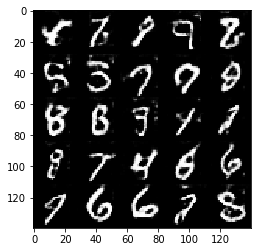

Epochs 1,batches 2510, dis_loss 1.1780129671096802 , gen_loss 0.8655062913894653
Epochs 1,batches 2520, dis_loss 0.9762924909591675 , gen_loss 0.9939480423927307
Epochs 1,batches 2530, dis_loss 1.6566835641860962 , gen_loss 0.3970058560371399
Epochs 1,batches 2540, dis_loss 1.1701719760894775 , gen_loss 1.0547356605529785
Epochs 1,batches 2550, dis_loss 0.964292585849762 , gen_loss 1.3385831117630005
Epochs 1,batches 2560, dis_loss 1.023024082183838 , gen_loss 0.8945562243461609
Epochs 1,batches 2570, dis_loss 1.2556719779968262 , gen_loss 0.6351391077041626
Epochs 1,batches 2580, dis_loss 1.1765612363815308 , gen_loss 0.6143616437911987
Epochs 1,batches 2590, dis_loss 1.0488007068634033 , gen_loss 0.92087322473526
Epochs 1,batches 2600, dis_loss 1.328018307685852 , gen_loss 0.5972270965576172


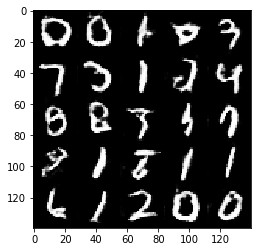

Epochs 1,batches 2610, dis_loss 1.096473217010498 , gen_loss 0.9646954536437988
Epochs 1,batches 2620, dis_loss 1.0448815822601318 , gen_loss 0.7152335047721863
Epochs 1,batches 2630, dis_loss 0.8815109729766846 , gen_loss 1.173736572265625
Epochs 1,batches 2640, dis_loss 0.9834429025650024 , gen_loss 0.8922795057296753
Epochs 1,batches 2650, dis_loss 1.2640109062194824 , gen_loss 1.8130605220794678
Epochs 1,batches 2660, dis_loss 1.0843069553375244 , gen_loss 0.7555075883865356
Epochs 1,batches 2670, dis_loss 1.3898036479949951 , gen_loss 0.5223928093910217
Epochs 1,batches 2680, dis_loss 1.1892056465148926 , gen_loss 1.0456397533416748
Epochs 1,batches 2690, dis_loss 1.0677387714385986 , gen_loss 1.003501534461975
Epochs 1,batches 2700, dis_loss 0.8611147403717041 , gen_loss 0.992803692817688


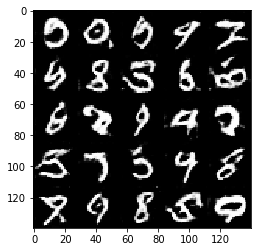

Epochs 1,batches 2710, dis_loss 1.3319945335388184 , gen_loss 0.5780717134475708
Epochs 1,batches 2720, dis_loss 1.279015064239502 , gen_loss 0.6434803009033203
Epochs 1,batches 2730, dis_loss 0.9249700903892517 , gen_loss 1.2875885963439941
Epochs 1,batches 2740, dis_loss 1.1234831809997559 , gen_loss 1.066619873046875
Epochs 1,batches 2750, dis_loss 0.8421869874000549 , gen_loss 1.2190057039260864
Epochs 1,batches 2760, dis_loss 1.3018519878387451 , gen_loss 2.0423483848571777
Epochs 1,batches 2770, dis_loss 0.9423946738243103 , gen_loss 1.0577144622802734
Epochs 1,batches 2780, dis_loss 1.086071491241455 , gen_loss 0.8587868213653564
Epochs 1,batches 2790, dis_loss 1.4243934154510498 , gen_loss 0.5609021186828613
Epochs 1,batches 2800, dis_loss 1.1620738506317139 , gen_loss 0.8662595152854919


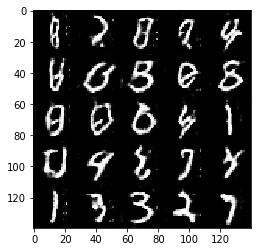

Epochs 1,batches 2810, dis_loss 1.2686692476272583 , gen_loss 0.5464541912078857
Epochs 1,batches 2820, dis_loss 0.9387158155441284 , gen_loss 1.2857952117919922
Epochs 1,batches 2830, dis_loss 1.0646663904190063 , gen_loss 0.8737595677375793
Epochs 1,batches 2840, dis_loss 0.7921093106269836 , gen_loss 1.4593427181243896
Epochs 1,batches 2850, dis_loss 1.0681345462799072 , gen_loss 0.8506879210472107
Epochs 1,batches 2860, dis_loss 0.8348028659820557 , gen_loss 1.2168364524841309
Epochs 1,batches 2870, dis_loss 1.135872483253479 , gen_loss 0.5898278951644897
Epochs 1,batches 2880, dis_loss 1.11217200756073 , gen_loss 0.7050253748893738
Epochs 1,batches 2890, dis_loss 0.8511408567428589 , gen_loss 1.3622643947601318
Epochs 1,batches 2900, dis_loss 0.8784739971160889 , gen_loss 1.5151572227478027


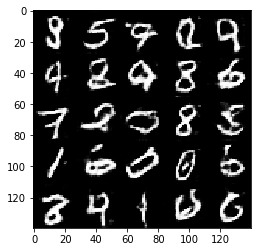

Epochs 1,batches 2910, dis_loss 1.3114573955535889 , gen_loss 0.5631967186927795
Epochs 1,batches 2920, dis_loss 1.7153645753860474 , gen_loss 2.6900925636291504
Epochs 1,batches 2930, dis_loss 0.8373365998268127 , gen_loss 0.9662694931030273
Epochs 1,batches 2940, dis_loss 1.1903157234191895 , gen_loss 0.9137683510780334
Epochs 1,batches 2950, dis_loss 1.200713872909546 , gen_loss 0.8074904680252075
Epochs 1,batches 2960, dis_loss 0.91539466381073 , gen_loss 1.4553427696228027
Epochs 1,batches 2970, dis_loss 0.8867809772491455 , gen_loss 1.0563335418701172
Epochs 1,batches 2980, dis_loss 1.0508718490600586 , gen_loss 1.4930458068847656
Epochs 1,batches 2990, dis_loss 1.0552430152893066 , gen_loss 1.2265247106552124
Epochs 1,batches 3000, dis_loss 0.9080144166946411 , gen_loss 1.153795599937439


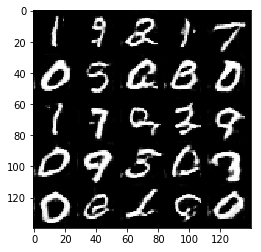

Epochs 1,batches 3010, dis_loss 1.1233174800872803 , gen_loss 0.8146582841873169
Epochs 1,batches 3020, dis_loss 1.1571112871170044 , gen_loss 0.6719018220901489
Epochs 1,batches 3030, dis_loss 0.6726359724998474 , gen_loss 1.6354269981384277
Epochs 1,batches 3040, dis_loss 1.2221572399139404 , gen_loss 2.2303028106689453
Epochs 1,batches 3050, dis_loss 0.962601363658905 , gen_loss 1.2412731647491455
Epochs 1,batches 3060, dis_loss 0.8886179327964783 , gen_loss 0.9752839803695679
Epochs 1,batches 3070, dis_loss 1.4383823871612549 , gen_loss 0.516594409942627
Epochs 1,batches 3080, dis_loss 1.1789538860321045 , gen_loss 0.746458113193512
Epochs 1,batches 3090, dis_loss 0.9320665597915649 , gen_loss 1.1862820386886597
Epochs 1,batches 3100, dis_loss 1.186355710029602 , gen_loss 1.439253568649292


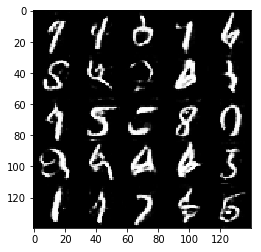

Epochs 1,batches 3110, dis_loss 0.997747540473938 , gen_loss 0.9031709432601929
Epochs 1,batches 3120, dis_loss 1.1577225923538208 , gen_loss 0.7386288642883301
Epochs 1,batches 3130, dis_loss 1.18118155002594 , gen_loss 0.7294456958770752
Epochs 1,batches 3140, dis_loss 0.9129397869110107 , gen_loss 1.416244626045227
Epochs 1,batches 3150, dis_loss 1.1933908462524414 , gen_loss 0.6460878849029541
Epochs 1,batches 3160, dis_loss 0.9404956698417664 , gen_loss 1.970212697982788
Epochs 1,batches 3170, dis_loss 1.4503488540649414 , gen_loss 0.5001856088638306
Epochs 1,batches 3180, dis_loss 1.1926499605178833 , gen_loss 0.7106391191482544
Epochs 1,batches 3190, dis_loss 0.8766297698020935 , gen_loss 1.662311315536499
Epochs 1,batches 3200, dis_loss 0.6947897672653198 , gen_loss 1.5985374450683594


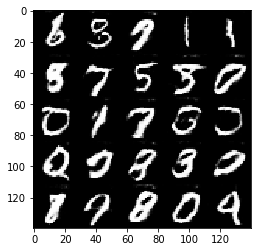

Epochs 1,batches 3210, dis_loss 1.4592978954315186 , gen_loss 0.4727718234062195
Epochs 1,batches 3220, dis_loss 1.019824743270874 , gen_loss 0.9780660271644592
Epochs 1,batches 3230, dis_loss 1.3045594692230225 , gen_loss 0.5562233924865723
Epochs 1,batches 3240, dis_loss 0.7797743678092957 , gen_loss 1.5650014877319336
Epochs 1,batches 3250, dis_loss 0.844071626663208 , gen_loss 1.089532494544983
Epochs 1,batches 3260, dis_loss 1.464966058731079 , gen_loss 2.420742988586426
Epochs 1,batches 3270, dis_loss 1.2699326276779175 , gen_loss 0.608762264251709
Epochs 1,batches 3280, dis_loss 1.0462112426757812 , gen_loss 0.9551607370376587
Epochs 1,batches 3290, dis_loss 0.9500535726547241 , gen_loss 1.3433446884155273
Epochs 1,batches 3300, dis_loss 0.8281538486480713 , gen_loss 1.4746276140213013


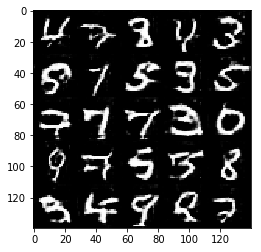

Epochs 1,batches 3310, dis_loss 0.7624537944793701 , gen_loss 1.7368812561035156
Epochs 2,batches 3320, dis_loss 1.1331194639205933 , gen_loss 0.7959703207015991
Epochs 2,batches 3330, dis_loss 0.9752991199493408 , gen_loss 1.2743000984191895
Epochs 2,batches 3340, dis_loss 0.8934837579727173 , gen_loss 0.9746541976928711
Epochs 2,batches 3350, dis_loss 0.9197949171066284 , gen_loss 0.9026861190795898
Epochs 2,batches 3360, dis_loss 1.0114219188690186 , gen_loss 0.8536347150802612
Epochs 2,batches 3370, dis_loss 1.1278281211853027 , gen_loss 0.7396085858345032
Epochs 2,batches 3380, dis_loss 1.2661490440368652 , gen_loss 0.7277543544769287
Epochs 2,batches 3390, dis_loss 0.8658398389816284 , gen_loss 1.603195071220398
Epochs 2,batches 3400, dis_loss 0.9288986921310425 , gen_loss 1.5144730806350708


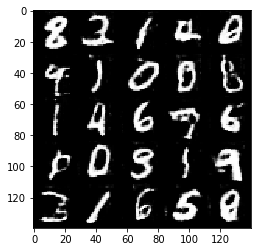

Epochs 2,batches 3410, dis_loss 1.053470492362976 , gen_loss 0.8405452966690063
Epochs 2,batches 3420, dis_loss 0.923156201839447 , gen_loss 1.0067799091339111
Epochs 2,batches 3430, dis_loss 0.972486138343811 , gen_loss 0.8634293675422668
Epochs 2,batches 3440, dis_loss 1.162327766418457 , gen_loss 0.6606680154800415
Epochs 2,batches 3450, dis_loss 1.0145363807678223 , gen_loss 0.8288440108299255
Epochs 2,batches 3460, dis_loss 0.8971982598304749 , gen_loss 1.0394890308380127
Epochs 2,batches 3470, dis_loss 1.1923248767852783 , gen_loss 0.6647307872772217
Epochs 2,batches 3480, dis_loss 0.9974756836891174 , gen_loss 1.3907747268676758
Epochs 2,batches 3490, dis_loss 0.9877250790596008 , gen_loss 0.9471296072006226
Epochs 2,batches 3500, dis_loss 0.886040210723877 , gen_loss 1.0170201063156128


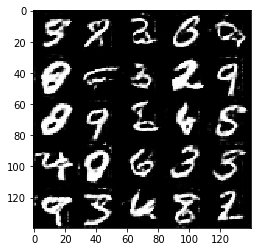

Epochs 2,batches 3510, dis_loss 0.7937284111976624 , gen_loss 1.1619832515716553
Epochs 2,batches 3520, dis_loss 0.9985384941101074 , gen_loss 1.1355342864990234
Epochs 2,batches 3530, dis_loss 1.1407170295715332 , gen_loss 1.780407190322876
Epochs 2,batches 3540, dis_loss 1.0510610342025757 , gen_loss 1.0871202945709229
Epochs 2,batches 3550, dis_loss 1.0949040651321411 , gen_loss 0.7866228818893433
Epochs 2,batches 3560, dis_loss 1.0439352989196777 , gen_loss 1.1333131790161133
Epochs 2,batches 3570, dis_loss 1.1943175792694092 , gen_loss 0.9049817323684692
Epochs 2,batches 3580, dis_loss 0.9338477253913879 , gen_loss 0.9801135659217834
Epochs 2,batches 3590, dis_loss 0.9644981622695923 , gen_loss 0.9436888694763184
Epochs 2,batches 3600, dis_loss 0.7982985973358154 , gen_loss 1.1261816024780273


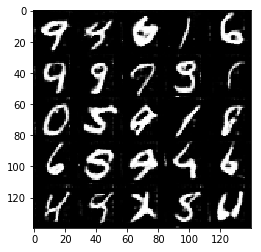

Epochs 2,batches 3610, dis_loss 1.3049235343933105 , gen_loss 0.5200240015983582
Epochs 2,batches 3620, dis_loss 1.2715716361999512 , gen_loss 0.6969195604324341
Epochs 2,batches 3630, dis_loss 0.8633889555931091 , gen_loss 1.1427689790725708
Epochs 2,batches 3640, dis_loss 0.9603464007377625 , gen_loss 1.0175975561141968
Epochs 2,batches 3650, dis_loss 0.9412593841552734 , gen_loss 2.1436667442321777
Epochs 2,batches 3660, dis_loss 0.7818169593811035 , gen_loss 1.7691729068756104
Epochs 2,batches 3670, dis_loss 0.7409242391586304 , gen_loss 1.4584368467330933
Epochs 2,batches 3680, dis_loss 0.7914012670516968 , gen_loss 1.5737959146499634
Epochs 2,batches 3690, dis_loss 1.0095746517181396 , gen_loss 0.9701032638549805
Epochs 2,batches 3700, dis_loss 0.7947437763214111 , gen_loss 1.2231040000915527


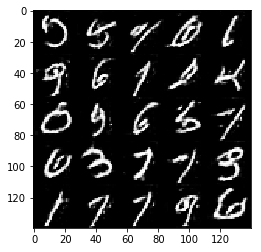

Epochs 2,batches 3710, dis_loss 2.3712639808654785 , gen_loss 0.22785773873329163
Epochs 2,batches 3720, dis_loss 0.8988497257232666 , gen_loss 1.189683198928833
Epochs 2,batches 3730, dis_loss 0.7252128720283508 , gen_loss 1.4031732082366943
Epochs 2,batches 3740, dis_loss 1.1203070878982544 , gen_loss 1.5261468887329102
Epochs 2,batches 3750, dis_loss 0.8265873789787292 , gen_loss 1.2412948608398438
Epochs 2,batches 3760, dis_loss 0.771485447883606 , gen_loss 1.1664538383483887
Epochs 2,batches 3770, dis_loss 1.104043960571289 , gen_loss 2.5103697776794434
Epochs 2,batches 3780, dis_loss 0.8215410709381104 , gen_loss 1.1787536144256592
Epochs 2,batches 3790, dis_loss 0.6547667980194092 , gen_loss 1.7014074325561523
Epochs 2,batches 3800, dis_loss 1.183504581451416 , gen_loss 1.6160533428192139


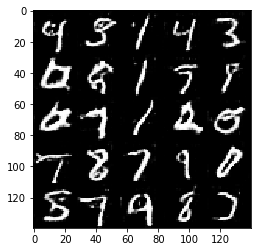

Epochs 2,batches 3810, dis_loss 0.8660271167755127 , gen_loss 2.141706943511963
Epochs 2,batches 3820, dis_loss 1.1030653715133667 , gen_loss 0.7831417918205261
Epochs 2,batches 3830, dis_loss 1.4675039052963257 , gen_loss 0.5627545118331909
Epochs 2,batches 3840, dis_loss 1.0604033470153809 , gen_loss 0.9769798517227173
Epochs 2,batches 3850, dis_loss 0.7266861200332642 , gen_loss 1.3358179330825806
Epochs 2,batches 3860, dis_loss 0.6620188355445862 , gen_loss 1.3293404579162598
Epochs 2,batches 3870, dis_loss 1.3002132177352905 , gen_loss 0.5979290008544922
Epochs 2,batches 3880, dis_loss 0.8269068598747253 , gen_loss 1.3975698947906494
Epochs 2,batches 3890, dis_loss 0.8737084865570068 , gen_loss 1.2457046508789062
Epochs 2,batches 3900, dis_loss 0.6106216907501221 , gen_loss 2.2900636196136475


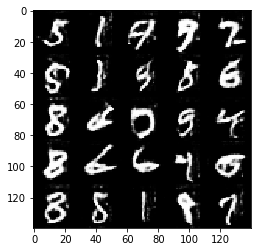

Epochs 2,batches 3910, dis_loss 0.759958028793335 , gen_loss 1.3920753002166748
Epochs 2,batches 3920, dis_loss 0.8020796775817871 , gen_loss 1.5811235904693604
Epochs 2,batches 3930, dis_loss 0.8070595264434814 , gen_loss 1.8583576679229736
Epochs 2,batches 3940, dis_loss 0.8780224323272705 , gen_loss 1.5564889907836914
Epochs 2,batches 3950, dis_loss 0.7373627424240112 , gen_loss 1.2943788766860962
Epochs 2,batches 3960, dis_loss 1.2229341268539429 , gen_loss 0.7410591840744019
Epochs 2,batches 3970, dis_loss 1.2295546531677246 , gen_loss 0.638648509979248
Epochs 2,batches 3980, dis_loss 0.7701390981674194 , gen_loss 1.4664030075073242
Epochs 2,batches 3990, dis_loss 0.938015341758728 , gen_loss 1.0521678924560547
Epochs 2,batches 4000, dis_loss 1.831427812576294 , gen_loss 3.14414644241333


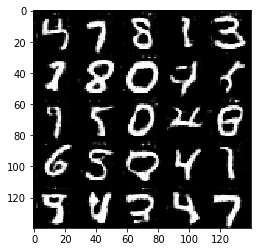

Epochs 2,batches 4010, dis_loss 0.9326453804969788 , gen_loss 0.8144791722297668
Epochs 2,batches 4020, dis_loss 1.010873556137085 , gen_loss 1.1040611267089844
Epochs 2,batches 4030, dis_loss 0.7995551228523254 , gen_loss 1.1048269271850586
Epochs 2,batches 4040, dis_loss 0.6925896406173706 , gen_loss 1.9280002117156982
Epochs 2,batches 4050, dis_loss 0.7186533808708191 , gen_loss 1.7461144924163818
Epochs 2,batches 4060, dis_loss 1.1364308595657349 , gen_loss 0.7001946568489075
Epochs 2,batches 4070, dis_loss 1.1509958505630493 , gen_loss 0.7583587169647217
Epochs 2,batches 4080, dis_loss 0.6120309233665466 , gen_loss 1.5532522201538086
Epochs 2,batches 4090, dis_loss 0.7051268815994263 , gen_loss 1.3329265117645264
Epochs 2,batches 4100, dis_loss 1.1444692611694336 , gen_loss 0.7782504558563232


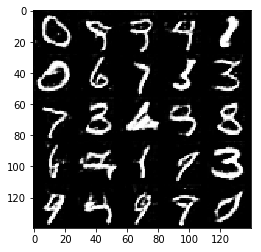

Epochs 2,batches 4110, dis_loss 1.2523000240325928 , gen_loss 0.6421953439712524
Epochs 2,batches 4120, dis_loss 0.5853214859962463 , gen_loss 1.6155219078063965
Epochs 2,batches 4130, dis_loss 1.2872884273529053 , gen_loss 0.5783067345619202
Epochs 2,batches 4140, dis_loss 1.1609398126602173 , gen_loss 2.12949800491333
Epochs 2,batches 4150, dis_loss 0.8204237818717957 , gen_loss 1.279486894607544
Epochs 2,batches 4160, dis_loss 0.9332616925239563 , gen_loss 1.0916781425476074
Epochs 2,batches 4170, dis_loss 0.9833377599716187 , gen_loss 1.0432300567626953
Epochs 2,batches 4180, dis_loss 0.9110789895057678 , gen_loss 0.9960430860519409
Epochs 2,batches 4190, dis_loss 1.0796432495117188 , gen_loss 1.0859322547912598
Epochs 2,batches 4200, dis_loss 0.9437260627746582 , gen_loss 1.5711815357208252


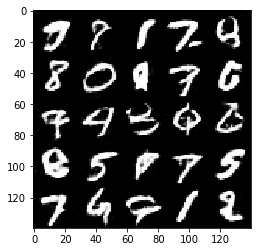

Epochs 2,batches 4210, dis_loss 0.7841377854347229 , gen_loss 1.2238898277282715
Epochs 2,batches 4220, dis_loss 0.737525224685669 , gen_loss 1.8191298246383667
Epochs 2,batches 4230, dis_loss 0.6281039714813232 , gen_loss 1.5365625619888306
Epochs 2,batches 4240, dis_loss 0.8739577531814575 , gen_loss 0.9700056910514832
Epochs 2,batches 4250, dis_loss 1.144667625427246 , gen_loss 0.8072599172592163
Epochs 2,batches 4260, dis_loss 0.7206025123596191 , gen_loss 1.727864384651184
Epochs 2,batches 4270, dis_loss 0.7833336591720581 , gen_loss 1.2604436874389648
Epochs 2,batches 4280, dis_loss 0.7913298606872559 , gen_loss 1.401261568069458
Epochs 2,batches 4290, dis_loss 0.9640255570411682 , gen_loss 1.0148887634277344
Epochs 2,batches 4300, dis_loss 1.1469991207122803 , gen_loss 0.7280283570289612


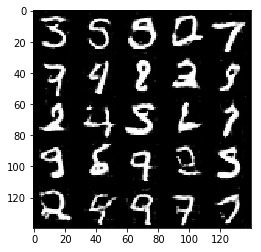

Epochs 2,batches 4310, dis_loss 0.7615595459938049 , gen_loss 1.4989664554595947
Epochs 2,batches 4320, dis_loss 1.0212050676345825 , gen_loss 0.9376251697540283
Epochs 2,batches 4330, dis_loss 0.9493387937545776 , gen_loss 2.2219057083129883
Epochs 2,batches 4340, dis_loss 1.43940007686615 , gen_loss 1.9645652770996094
Epochs 2,batches 4350, dis_loss 0.7969660758972168 , gen_loss 1.7932772636413574
Epochs 2,batches 4360, dis_loss 0.8576987385749817 , gen_loss 1.0059094429016113
Epochs 2,batches 4370, dis_loss 0.8822094798088074 , gen_loss 1.2598378658294678
Epochs 2,batches 4380, dis_loss 0.6679646372795105 , gen_loss 1.971561074256897
Epochs 2,batches 4390, dis_loss 0.6870917081832886 , gen_loss 1.9223757982254028
Epochs 2,batches 4400, dis_loss 0.9905354380607605 , gen_loss 0.9879578948020935


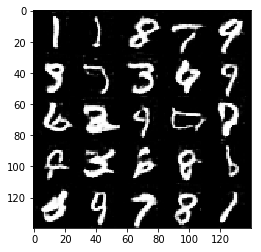

Epochs 2,batches 4410, dis_loss 0.7960377931594849 , gen_loss 2.4343981742858887
Epochs 2,batches 4420, dis_loss 1.0246031284332275 , gen_loss 0.8730412721633911
Epochs 2,batches 4430, dis_loss 1.414472222328186 , gen_loss 2.0891523361206055
Epochs 2,batches 4440, dis_loss 0.8189061880111694 , gen_loss 1.2253657579421997
Epochs 2,batches 4450, dis_loss 0.8384568691253662 , gen_loss 1.08098304271698
Epochs 2,batches 4460, dis_loss 0.9232969284057617 , gen_loss 1.9223814010620117
Epochs 2,batches 4470, dis_loss 0.8105332255363464 , gen_loss 1.4797642230987549
Epochs 2,batches 4480, dis_loss 0.8938199281692505 , gen_loss 1.4325847625732422
Epochs 2,batches 4490, dis_loss 0.811521589756012 , gen_loss 1.100895643234253
Epochs 2,batches 4500, dis_loss 1.179492473602295 , gen_loss 0.7642220258712769


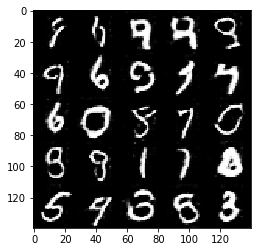

Epochs 2,batches 4510, dis_loss 1.2524445056915283 , gen_loss 0.8567649126052856
Epochs 2,batches 4520, dis_loss 0.6562989950180054 , gen_loss 1.9448511600494385
Epochs 2,batches 4530, dis_loss 0.9767729043960571 , gen_loss 1.229708194732666
Epochs 2,batches 4540, dis_loss 0.9167784452438354 , gen_loss 1.1029456853866577
Epochs 2,batches 4550, dis_loss 0.6818210482597351 , gen_loss 1.3973007202148438
Epochs 2,batches 4560, dis_loss 1.0990735292434692 , gen_loss 0.8816635608673096
Epochs 2,batches 4570, dis_loss 1.2115156650543213 , gen_loss 0.7167340517044067
Epochs 2,batches 4580, dis_loss 1.116663932800293 , gen_loss 0.7186794281005859
Epochs 2,batches 4590, dis_loss 1.5299723148345947 , gen_loss 0.3818551301956177
Epochs 2,batches 4600, dis_loss 1.2847157716751099 , gen_loss 0.6459676027297974


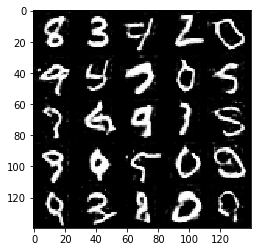

Epochs 2,batches 4610, dis_loss 0.6148280501365662 , gen_loss 1.6703574657440186
Epochs 2,batches 4620, dis_loss 0.8947650194168091 , gen_loss 1.2838542461395264
Epochs 2,batches 4630, dis_loss 1.6589229106903076 , gen_loss 2.385488510131836
Epochs 2,batches 4640, dis_loss 0.803019642829895 , gen_loss 1.6569416522979736
Epochs 2,batches 4650, dis_loss 1.0585278272628784 , gen_loss 0.7533430457115173
Epochs 2,batches 4660, dis_loss 0.8681190609931946 , gen_loss 1.1089413166046143
Epochs 2,batches 4670, dis_loss 0.9651503562927246 , gen_loss 1.336455225944519
Epochs 2,batches 4680, dis_loss 1.1267118453979492 , gen_loss 0.7422888875007629
Epochs 2,batches 4690, dis_loss 0.9448599815368652 , gen_loss 1.3138165473937988
Epochs 2,batches 4700, dis_loss 0.7584149241447449 , gen_loss 1.5680232048034668


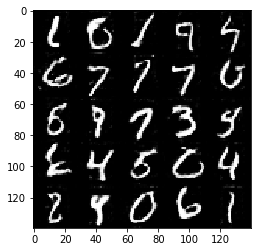

Epochs 2,batches 4710, dis_loss 0.9551213383674622 , gen_loss 0.7271736860275269
Epochs 2,batches 4720, dis_loss 0.7097957134246826 , gen_loss 2.9054694175720215
Epochs 2,batches 4730, dis_loss 0.6992182731628418 , gen_loss 1.5512720346450806
Epochs 2,batches 4740, dis_loss 1.6089661121368408 , gen_loss 0.4233967959880829
Epochs 2,batches 4750, dis_loss 1.3062713146209717 , gen_loss 0.49366727471351624
Epochs 2,batches 4760, dis_loss 0.6976404190063477 , gen_loss 1.2704042196273804
Epochs 2,batches 4770, dis_loss 0.9454220533370972 , gen_loss 1.0655176639556885
Epochs 2,batches 4780, dis_loss 1.3858227729797363 , gen_loss 0.4494553208351135
Epochs 2,batches 4790, dis_loss 0.8423272371292114 , gen_loss 1.5740331411361694
Epochs 2,batches 4800, dis_loss 0.9472973942756653 , gen_loss 0.9292058944702148


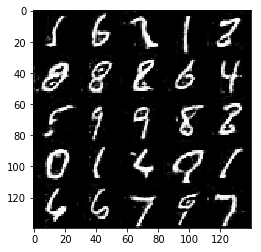

Epochs 2,batches 4810, dis_loss 1.060404658317566 , gen_loss 2.130978584289551
Epochs 2,batches 4820, dis_loss 0.7309374809265137 , gen_loss 1.3045490980148315
Epochs 2,batches 4830, dis_loss 0.6586049199104309 , gen_loss 1.426044225692749
Epochs 2,batches 4840, dis_loss 0.8185786008834839 , gen_loss 1.170539140701294
Epochs 2,batches 4850, dis_loss 0.7456011772155762 , gen_loss 1.7738239765167236
Epochs 2,batches 4860, dis_loss 1.1018683910369873 , gen_loss 0.862247109413147
Epochs 2,batches 4870, dis_loss 0.7612930536270142 , gen_loss 1.310255765914917
Epochs 2,batches 4880, dis_loss 1.1361526250839233 , gen_loss 0.9884220957756042
Epochs 2,batches 4890, dis_loss 1.2468187808990479 , gen_loss 0.7637207508087158
Epochs 2,batches 4900, dis_loss 0.9946458339691162 , gen_loss 1.167860984802246


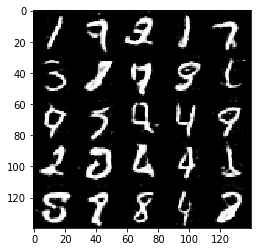

Epochs 2,batches 4910, dis_loss 0.869692862033844 , gen_loss 1.0294864177703857
Epochs 2,batches 4920, dis_loss 1.128941535949707 , gen_loss 1.4620919227600098
Epochs 2,batches 4930, dis_loss 0.7100856900215149 , gen_loss 1.2244136333465576
Epochs 2,batches 4940, dis_loss 0.8973188996315002 , gen_loss 1.9874390363693237
Epochs 2,batches 4950, dis_loss 0.7753808498382568 , gen_loss 1.463942527770996
Epochs 2,batches 4960, dis_loss 1.3526620864868164 , gen_loss 3.3185877799987793
Epochs 2,batches 4970, dis_loss 0.8798112869262695 , gen_loss 1.6139482259750366
Epochs 2,batches 4980, dis_loss 0.6369646787643433 , gen_loss 1.7441086769104004
Epochs 2,batches 4990, dis_loss 0.7072408199310303 , gen_loss 1.381197452545166
Epochs 2,batches 5000, dis_loss 0.8863893747329712 , gen_loss 1.0875705480575562


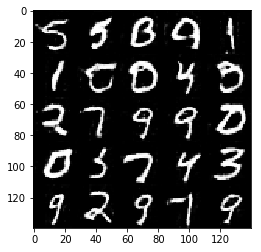

Epochs 2,batches 5010, dis_loss 0.7925152778625488 , gen_loss 1.4115278720855713
Epochs 2,batches 5020, dis_loss 1.0567924976348877 , gen_loss 1.0427147150039673
Epochs 2,batches 5030, dis_loss 0.8745312094688416 , gen_loss 1.1792250871658325
Epochs 2,batches 5040, dis_loss 1.3700131177902222 , gen_loss 0.6882370710372925
Epochs 2,batches 5050, dis_loss 1.2018470764160156 , gen_loss 0.6861483454704285
Epochs 2,batches 5060, dis_loss 0.9770663976669312 , gen_loss 1.05220365524292
Epochs 2,batches 5070, dis_loss 0.7040005922317505 , gen_loss 1.6828868389129639
Epochs 2,batches 5080, dis_loss 0.8217240571975708 , gen_loss 2.0165398120880127
Epochs 2,batches 5090, dis_loss 0.8595942258834839 , gen_loss 0.9013400673866272
Epochs 2,batches 5100, dis_loss 0.6333856582641602 , gen_loss 1.422207236289978


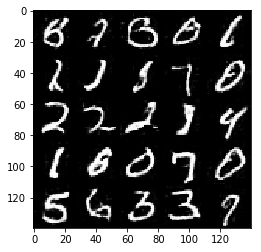

Epochs 2,batches 5110, dis_loss 0.7159425020217896 , gen_loss 1.2904562950134277
Epochs 2,batches 5120, dis_loss 0.786235511302948 , gen_loss 1.2777073383331299
Epochs 2,batches 5130, dis_loss 0.7529128789901733 , gen_loss 2.0027341842651367
Epochs 2,batches 5140, dis_loss 1.2223502397537231 , gen_loss 0.6010696291923523
Epochs 2,batches 5150, dis_loss 0.6434316635131836 , gen_loss 1.730971097946167
Epochs 2,batches 5160, dis_loss 0.9076664447784424 , gen_loss 1.0580321550369263
Epochs 2,batches 5170, dis_loss 1.1387253999710083 , gen_loss 0.5040957927703857
Epochs 2,batches 5180, dis_loss 1.2968980073928833 , gen_loss 0.5908863544464111
Epochs 2,batches 5190, dis_loss 0.752282977104187 , gen_loss 1.3075611591339111
Epochs 2,batches 5200, dis_loss 1.11836838722229 , gen_loss 0.723994255065918


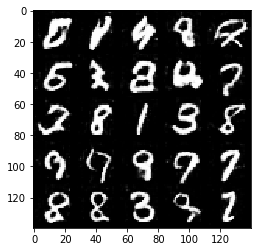

Epochs 2,batches 5210, dis_loss 0.7800282835960388 , gen_loss 1.3716843128204346
Epochs 2,batches 5220, dis_loss 0.9179368019104004 , gen_loss 0.9901834726333618
Epochs 2,batches 5230, dis_loss 1.0870616436004639 , gen_loss 2.699263095855713
Epochs 2,batches 5240, dis_loss 1.548299789428711 , gen_loss 0.6046263575553894
Epochs 2,batches 5250, dis_loss 0.9568580985069275 , gen_loss 0.7502604126930237
Epochs 2,batches 5260, dis_loss 0.8291906118392944 , gen_loss 1.364251732826233
Epochs 2,batches 5270, dis_loss 0.867648184299469 , gen_loss 1.313920021057129
Epochs 2,batches 5280, dis_loss 1.0024622678756714 , gen_loss 0.8466507196426392
Epochs 2,batches 5290, dis_loss 0.6646525263786316 , gen_loss 1.914193868637085
Epochs 2,batches 5300, dis_loss 0.8950973153114319 , gen_loss 1.4248263835906982


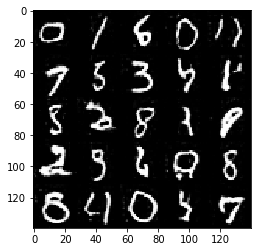

Epochs 2,batches 5310, dis_loss 0.9940977096557617 , gen_loss 0.9265256524085999
Epochs 2,batches 5320, dis_loss 0.7920839786529541 , gen_loss 1.215468406677246
Epochs 2,batches 5330, dis_loss 1.0647368431091309 , gen_loss 0.9557034969329834
Epochs 2,batches 5340, dis_loss 0.9301400184631348 , gen_loss 1.2817872762680054
Epochs 2,batches 5350, dis_loss 0.9349108338356018 , gen_loss 0.8864948749542236
Epochs 2,batches 5360, dis_loss 1.1086610555648804 , gen_loss 2.3745009899139404
Epochs 2,batches 5370, dis_loss 0.754371702671051 , gen_loss 1.1744685173034668
Epochs 2,batches 5380, dis_loss 0.5845056176185608 , gen_loss 2.4742283821105957
Epochs 2,batches 5390, dis_loss 0.7114576101303101 , gen_loss 1.5413771867752075
Epochs 2,batches 5400, dis_loss 0.6455637216567993 , gen_loss 1.7251930236816406


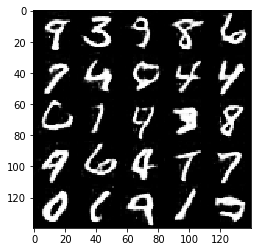

Epochs 2,batches 5410, dis_loss 0.734452486038208 , gen_loss 1.487581491470337
Epochs 2,batches 5420, dis_loss 0.5018800497055054 , gen_loss 2.0191705226898193
Epochs 2,batches 5430, dis_loss 2.1547133922576904 , gen_loss 2.56986141204834
Epochs 2,batches 5440, dis_loss 0.7094540596008301 , gen_loss 1.6061697006225586
Epochs 2,batches 5450, dis_loss 0.8711481094360352 , gen_loss 1.2399780750274658
Epochs 2,batches 5460, dis_loss 0.7358014583587646 , gen_loss 1.3933650255203247
Epochs 2,batches 5470, dis_loss 0.7063860893249512 , gen_loss 1.709437370300293
Epochs 2,batches 5480, dis_loss 0.7411560416221619 , gen_loss 1.060257911682129
Epochs 2,batches 5490, dis_loss 0.6498834490776062 , gen_loss 1.590294599533081
Epochs 2,batches 5500, dis_loss 0.7226147055625916 , gen_loss 1.6120951175689697


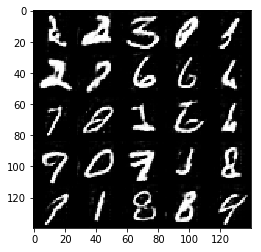

Epochs 2,batches 5510, dis_loss 1.7026820182800293 , gen_loss 0.4080919027328491
Epochs 2,batches 5520, dis_loss 0.7457765936851501 , gen_loss 1.615204930305481
Epochs 2,batches 5530, dis_loss 1.7903848886489868 , gen_loss 3.0679097175598145
Epochs 2,batches 5540, dis_loss 0.7622328400611877 , gen_loss 1.3419407606124878
Epochs 2,batches 5550, dis_loss 0.6998119354248047 , gen_loss 1.1309767961502075
Epochs 2,batches 5560, dis_loss 1.1178607940673828 , gen_loss 0.7535719871520996
Epochs 2,batches 5570, dis_loss 0.6571534872055054 , gen_loss 2.2888100147247314
Epochs 2,batches 5580, dis_loss 0.8617067337036133 , gen_loss 1.2033603191375732
Epochs 2,batches 5590, dis_loss 0.7390096187591553 , gen_loss 1.2441848516464233
Epochs 2,batches 5600, dis_loss 1.4375649690628052 , gen_loss 0.6588146686553955


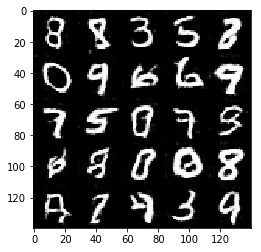

Epochs 2,batches 5610, dis_loss 1.1164402961730957 , gen_loss 0.7742561101913452
Epochs 2,batches 5620, dis_loss 0.6695592403411865 , gen_loss 1.6369736194610596
Epochs 2,batches 5630, dis_loss 1.075461745262146 , gen_loss 0.6648926734924316
Epochs 2,batches 5640, dis_loss 0.9784137010574341 , gen_loss 0.7993284463882446
Epochs 2,batches 5650, dis_loss 0.7591685056686401 , gen_loss 1.3610553741455078
Epochs 2,batches 5660, dis_loss 0.6250380277633667 , gen_loss 2.1360669136047363
Epochs 2,batches 5670, dis_loss 1.851506233215332 , gen_loss 0.4052978754043579
Epochs 2,batches 5680, dis_loss 0.9577077627182007 , gen_loss 0.9348121881484985
Epochs 2,batches 5690, dis_loss 0.8252394199371338 , gen_loss 0.8359159231185913
Epochs 2,batches 5700, dis_loss 0.8459227681159973 , gen_loss 1.0824023485183716


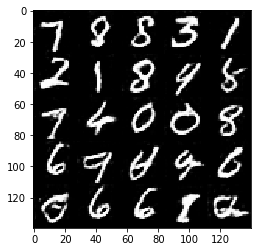

Epochs 2,batches 5710, dis_loss 0.5795129537582397 , gen_loss 1.8873367309570312
Epochs 2,batches 5720, dis_loss 0.8795923590660095 , gen_loss 1.019960880279541
Epochs 2,batches 5730, dis_loss 0.8973873257637024 , gen_loss 1.1159062385559082
Epochs 2,batches 5740, dis_loss 1.9020289182662964 , gen_loss 0.44792842864990234
Epochs 2,batches 5750, dis_loss 0.8958463668823242 , gen_loss 1.0716447830200195
Epochs 2,batches 5760, dis_loss 0.8040192723274231 , gen_loss 0.9981529116630554
Epochs 2,batches 5770, dis_loss 0.7923892140388489 , gen_loss 1.353104591369629
Epochs 2,batches 5780, dis_loss 1.0950074195861816 , gen_loss 0.6566044092178345
Epochs 2,batches 5790, dis_loss 0.6744829416275024 , gen_loss 1.251120686531067
Epochs 2,batches 5800, dis_loss 0.7878730297088623 , gen_loss 1.555145263671875


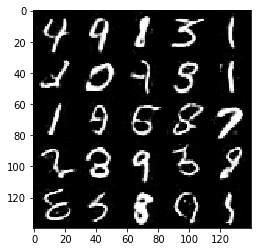

Epochs 2,batches 5810, dis_loss 1.3831453323364258 , gen_loss 3.252075672149658
Epochs 2,batches 5820, dis_loss 1.4499669075012207 , gen_loss 0.6433624029159546
Epochs 2,batches 5830, dis_loss 0.6163026690483093 , gen_loss 1.7806613445281982
Epochs 2,batches 5840, dis_loss 0.6867253184318542 , gen_loss 1.605422019958496
Epochs 2,batches 5850, dis_loss 0.7497584819793701 , gen_loss 1.8809196949005127
Epochs 2,batches 5860, dis_loss 0.5812497138977051 , gen_loss 2.2843446731567383
Epochs 2,batches 5870, dis_loss 0.6832042932510376 , gen_loss 1.6546106338500977
Epochs 2,batches 5880, dis_loss 0.6942763328552246 , gen_loss 2.45259952545166
Epochs 2,batches 5890, dis_loss 0.8921732306480408 , gen_loss 1.3220016956329346
Epochs 2,batches 5900, dis_loss 1.2599773406982422 , gen_loss 0.8386059999465942


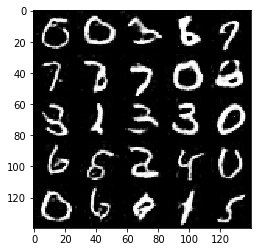

Epochs 2,batches 5910, dis_loss 0.8322272300720215 , gen_loss 0.9331556558609009
Epochs 2,batches 5920, dis_loss 1.3402718305587769 , gen_loss 0.6285932064056396
Epochs 2,batches 5930, dis_loss 0.6556545495986938 , gen_loss 1.9795613288879395
Epochs 2,batches 5940, dis_loss 0.9839417934417725 , gen_loss 0.9984720945358276
Epochs 2,batches 5950, dis_loss 0.49681758880615234 , gen_loss 1.9706387519836426
Epochs 2,batches 5960, dis_loss 0.7428412437438965 , gen_loss 1.4049659967422485
Epochs 2,batches 5970, dis_loss 0.8174906969070435 , gen_loss 1.3478564023971558
Epochs 2,batches 5980, dis_loss 1.2497916221618652 , gen_loss 0.6973732709884644
Epochs 2,batches 5990, dis_loss 1.4016534090042114 , gen_loss 3.0567212104797363
Epochs 2,batches 6000, dis_loss 1.3248686790466309 , gen_loss 0.8655428886413574


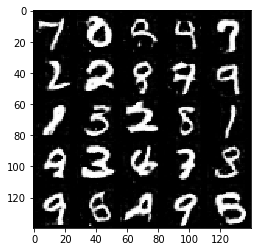

Epochs 2,batches 6010, dis_loss 1.4720700979232788 , gen_loss 0.5913757085800171
Epochs 2,batches 6020, dis_loss 0.7947714328765869 , gen_loss 1.865930199623108
Epochs 2,batches 6030, dis_loss 0.8712242841720581 , gen_loss 1.2385096549987793
Epochs 2,batches 6040, dis_loss 1.0791596174240112 , gen_loss 1.1934566497802734
Epochs 2,batches 6050, dis_loss 0.872818648815155 , gen_loss 1.2295622825622559
Epochs 2,batches 6060, dis_loss 0.7311152815818787 , gen_loss 1.454964280128479
Epochs 2,batches 6070, dis_loss 0.8347592353820801 , gen_loss 1.3484952449798584
Epochs 2,batches 6080, dis_loss 0.7524308562278748 , gen_loss 1.524552822113037
Epochs 2,batches 6090, dis_loss 0.6265379190444946 , gen_loss 1.6795399188995361
Epochs 2,batches 6100, dis_loss 0.8026648759841919 , gen_loss 1.417059063911438


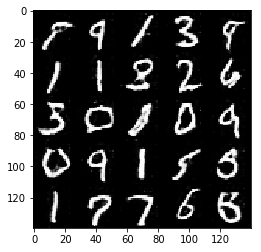

Epochs 2,batches 6110, dis_loss 0.640485942363739 , gen_loss 2.3099348545074463
Epochs 2,batches 6120, dis_loss 1.052875280380249 , gen_loss 0.7022809982299805
Epochs 2,batches 6130, dis_loss 0.6492785215377808 , gen_loss 2.127920627593994
Epochs 2,batches 6140, dis_loss 0.6759954690933228 , gen_loss 1.5439125299453735
Epochs 2,batches 6150, dis_loss 1.196533441543579 , gen_loss 1.7292978763580322
Epochs 2,batches 6160, dis_loss 0.5780189633369446 , gen_loss 1.604040503501892
Epochs 2,batches 6170, dis_loss 0.9006633758544922 , gen_loss 1.0942270755767822
Epochs 2,batches 6180, dis_loss 0.6759289503097534 , gen_loss 1.750067949295044
Epochs 2,batches 6190, dis_loss 0.9697374105453491 , gen_loss 0.9250379800796509
Epochs 2,batches 6200, dis_loss 0.8512258529663086 , gen_loss 1.1677660942077637


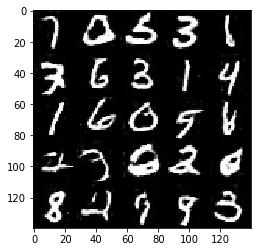

Epochs 2,batches 6210, dis_loss 0.6862913966178894 , gen_loss 2.320779800415039
Epochs 2,batches 6220, dis_loss 1.3386905193328857 , gen_loss 0.6253819465637207
Epochs 2,batches 6230, dis_loss 1.1627967357635498 , gen_loss 2.550976037979126
Epochs 2,batches 6240, dis_loss 0.9621634483337402 , gen_loss 1.1409233808517456
Epochs 2,batches 6250, dis_loss 0.6098242998123169 , gen_loss 2.188570976257324
Epochs 2,batches 6260, dis_loss 1.5190980434417725 , gen_loss 0.4594321846961975
Epochs 2,batches 6270, dis_loss 0.6431474089622498 , gen_loss 2.061253786087036
Epochs 2,batches 6280, dis_loss 1.0007123947143555 , gen_loss 0.7030301094055176
Epochs 2,batches 6290, dis_loss 0.8052380084991455 , gen_loss 1.9291664361953735
Epochs 2,batches 6300, dis_loss 0.7718835473060608 , gen_loss 1.3054723739624023


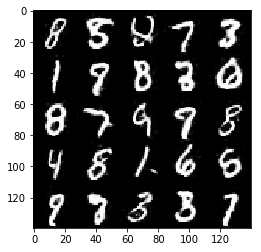

Epochs 2,batches 6310, dis_loss 0.7001217603683472 , gen_loss 1.5160155296325684
Epochs 2,batches 6320, dis_loss 0.9131931066513062 , gen_loss 1.3253417015075684
Epochs 2,batches 6330, dis_loss 1.6438297033309937 , gen_loss 3.363980531692505
Epochs 2,batches 6340, dis_loss 0.6146289110183716 , gen_loss 1.488448977470398
Epochs 2,batches 6350, dis_loss 0.9322087168693542 , gen_loss 1.084993600845337
Epochs 2,batches 6360, dis_loss 0.6265624761581421 , gen_loss 1.5345444679260254
Epochs 2,batches 6370, dis_loss 1.0385055541992188 , gen_loss 0.837896466255188
Epochs 2,batches 6380, dis_loss 0.7933578491210938 , gen_loss 1.19602370262146
Epochs 2,batches 6390, dis_loss 1.056541919708252 , gen_loss 0.8650140762329102
Epochs 2,batches 6400, dis_loss 0.6180367469787598 , gen_loss 1.4016108512878418


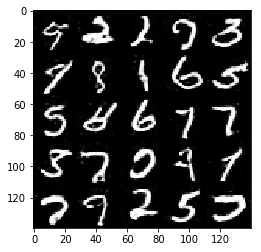

Epochs 2,batches 6410, dis_loss 1.1990951299667358 , gen_loss 2.1191506385803223
Epochs 2,batches 6420, dis_loss 0.6799197793006897 , gen_loss 2.051823139190674
Epochs 2,batches 6430, dis_loss 0.6442170739173889 , gen_loss 1.3491835594177246
Epochs 2,batches 6440, dis_loss 1.1570370197296143 , gen_loss 2.025967597961426
Epochs 2,batches 6450, dis_loss 0.7644336819648743 , gen_loss 1.6048697233200073
Epochs 2,batches 6460, dis_loss 0.7257802486419678 , gen_loss 1.3702800273895264
Epochs 2,batches 6470, dis_loss 1.402815341949463 , gen_loss 0.6992682814598083
Epochs 2,batches 6480, dis_loss 1.0947484970092773 , gen_loss 0.8789311647415161
Epochs 2,batches 6490, dis_loss 0.6631518602371216 , gen_loss 1.4801757335662842
Epochs 2,batches 6500, dis_loss 1.0044275522232056 , gen_loss 0.7670220136642456


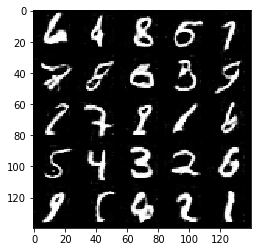

Epochs 2,batches 6510, dis_loss 0.6885986328125 , gen_loss 1.4607540369033813
Epochs 2,batches 6520, dis_loss 1.003779649734497 , gen_loss 0.9777610301971436
Epochs 2,batches 6530, dis_loss 0.6103783249855042 , gen_loss 1.932482361793518
Epochs 2,batches 6540, dis_loss 1.053395390510559 , gen_loss 0.8132573366165161
Epochs 2,batches 6550, dis_loss 2.2064242362976074 , gen_loss 0.4010547399520874
Epochs 2,batches 6560, dis_loss 0.6283553242683411 , gen_loss 1.8430614471435547
Epochs 2,batches 6570, dis_loss 0.6124985218048096 , gen_loss 2.192072868347168
Epochs 2,batches 6580, dis_loss 0.7543057799339294 , gen_loss 1.3235304355621338
Epochs 2,batches 6590, dis_loss 0.7238162755966187 , gen_loss 1.5918755531311035
Epochs 2,batches 6600, dis_loss 0.8165707588195801 , gen_loss 1.095648169517517


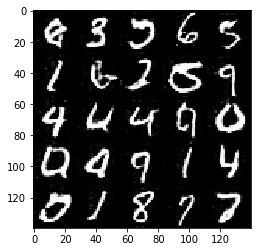

Epochs 2,batches 6610, dis_loss 0.8203933238983154 , gen_loss 1.1777235269546509
Epochs 2,batches 6620, dis_loss 0.8679511547088623 , gen_loss 1.1205276250839233


In [15]:
batch_size = 16
z_dim = 130
learning_rate = 0.0004
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


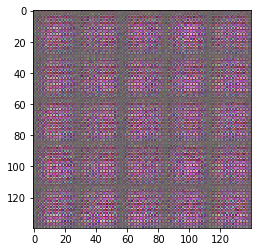

Epochs 1,batches 10, dis_loss 7.636246681213379 , gen_loss 0.0014061687979847193
Epochs 1,batches 20, dis_loss 2.3443942070007324 , gen_loss 0.44038569927215576
Epochs 1,batches 30, dis_loss 2.1971380710601807 , gen_loss 0.3146822452545166
Epochs 1,batches 40, dis_loss 2.008471965789795 , gen_loss 3.3465402126312256
Epochs 1,batches 50, dis_loss 1.6455734968185425 , gen_loss 1.2338550090789795
Epochs 1,batches 60, dis_loss 1.775350570678711 , gen_loss 2.1614089012145996
Epochs 1,batches 70, dis_loss 1.2904870510101318 , gen_loss 1.123323917388916
Epochs 1,batches 80, dis_loss 1.7495836019515991 , gen_loss 0.44492021203041077
Epochs 1,batches 90, dis_loss 1.3658254146575928 , gen_loss 0.696651816368103
Epochs 1,batches 100, dis_loss 1.7473461627960205 , gen_loss 0.5669982433319092


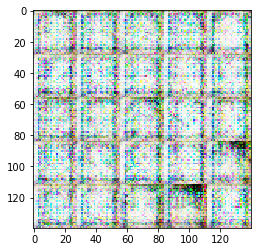

Epochs 1,batches 110, dis_loss 1.9280648231506348 , gen_loss 0.32082751393318176
Epochs 1,batches 120, dis_loss 1.9402865171432495 , gen_loss 0.3236999213695526
Epochs 1,batches 130, dis_loss 1.6501643657684326 , gen_loss 0.7333052158355713
Epochs 1,batches 140, dis_loss 1.6814687252044678 , gen_loss 0.6825481653213501
Epochs 1,batches 150, dis_loss 1.3617949485778809 , gen_loss 0.9582930207252502
Epochs 1,batches 160, dis_loss 1.4738940000534058 , gen_loss 1.372544288635254
Epochs 1,batches 170, dis_loss 1.4542266130447388 , gen_loss 1.5809102058410645
Epochs 1,batches 180, dis_loss 1.4886715412139893 , gen_loss 1.5347280502319336
Epochs 1,batches 190, dis_loss 1.3925923109054565 , gen_loss 1.499023675918579
Epochs 1,batches 200, dis_loss 1.4070477485656738 , gen_loss 1.0320312976837158


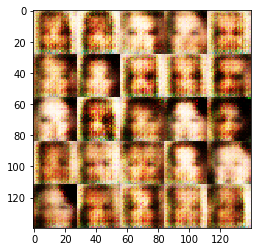

Epochs 1,batches 210, dis_loss 1.2803806066513062 , gen_loss 0.6430164575576782
Epochs 1,batches 220, dis_loss 1.8441100120544434 , gen_loss 1.5752592086791992
Epochs 1,batches 230, dis_loss 1.2871335744857788 , gen_loss 1.3568642139434814
Epochs 1,batches 240, dis_loss 1.7397180795669556 , gen_loss 1.4557852745056152
Epochs 1,batches 250, dis_loss 1.416794776916504 , gen_loss 0.5969650745391846
Epochs 1,batches 260, dis_loss 1.5456132888793945 , gen_loss 1.4084794521331787
Epochs 1,batches 270, dis_loss 1.3387781381607056 , gen_loss 0.960412323474884
Epochs 1,batches 280, dis_loss 1.7031891345977783 , gen_loss 1.3521783351898193
Epochs 1,batches 290, dis_loss 1.3400578498840332 , gen_loss 0.581620454788208
Epochs 1,batches 300, dis_loss 1.4349887371063232 , gen_loss 1.0832109451293945


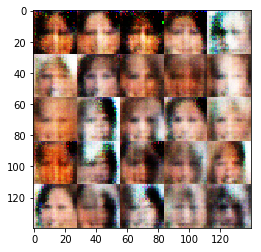

Epochs 1,batches 310, dis_loss 1.8200124502182007 , gen_loss 0.3299851417541504
Epochs 1,batches 320, dis_loss 1.3785300254821777 , gen_loss 0.9141614437103271
Epochs 1,batches 330, dis_loss 1.4620330333709717 , gen_loss 1.0139614343643188
Epochs 1,batches 340, dis_loss 1.5141594409942627 , gen_loss 0.47392022609710693
Epochs 1,batches 350, dis_loss 1.377180576324463 , gen_loss 1.0500553846359253
Epochs 1,batches 360, dis_loss 1.2905141115188599 , gen_loss 0.710918128490448
Epochs 1,batches 370, dis_loss 1.4750778675079346 , gen_loss 0.4694614112377167
Epochs 1,batches 380, dis_loss 1.3821731805801392 , gen_loss 0.8041406273841858
Epochs 1,batches 390, dis_loss 1.807868480682373 , gen_loss 0.29272758960723877
Epochs 1,batches 400, dis_loss 1.3349785804748535 , gen_loss 0.7109299302101135


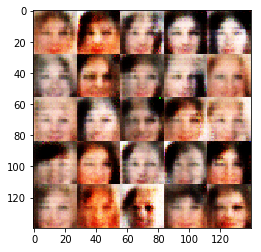

Epochs 1,batches 410, dis_loss 1.436972975730896 , gen_loss 1.0354615449905396
Epochs 1,batches 420, dis_loss 1.2312428951263428 , gen_loss 0.990592360496521
Epochs 1,batches 430, dis_loss 1.4834532737731934 , gen_loss 0.48769083619117737
Epochs 1,batches 440, dis_loss 1.5928735733032227 , gen_loss 0.4546084403991699
Epochs 1,batches 450, dis_loss 1.5214869976043701 , gen_loss 0.7411179542541504
Epochs 1,batches 460, dis_loss 1.478022575378418 , gen_loss 0.9124061465263367
Epochs 1,batches 470, dis_loss 1.3358540534973145 , gen_loss 0.9890626668930054
Epochs 1,batches 480, dis_loss 1.410043478012085 , gen_loss 0.731592059135437
Epochs 1,batches 490, dis_loss 1.39930260181427 , gen_loss 0.8429213166236877
Epochs 1,batches 500, dis_loss 1.5501914024353027 , gen_loss 0.6058767437934875


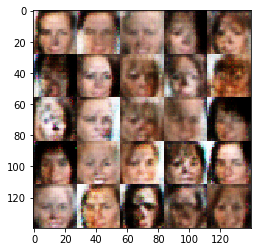

Epochs 1,batches 510, dis_loss 1.3587877750396729 , gen_loss 0.5815941691398621
Epochs 1,batches 520, dis_loss 1.5264794826507568 , gen_loss 0.5258645415306091
Epochs 1,batches 530, dis_loss 1.4477534294128418 , gen_loss 0.7524416446685791
Epochs 1,batches 540, dis_loss 1.3779385089874268 , gen_loss 1.0819270610809326
Epochs 1,batches 550, dis_loss 1.3925100564956665 , gen_loss 0.8404319286346436
Epochs 1,batches 560, dis_loss 1.6109435558319092 , gen_loss 0.9162067174911499
Epochs 1,batches 570, dis_loss 1.413865566253662 , gen_loss 0.7607748508453369
Epochs 1,batches 580, dis_loss 1.4334195852279663 , gen_loss 0.9146093130111694
Epochs 1,batches 590, dis_loss 1.5337932109832764 , gen_loss 0.5162453055381775
Epochs 1,batches 600, dis_loss 1.4461901187896729 , gen_loss 0.6850665807723999


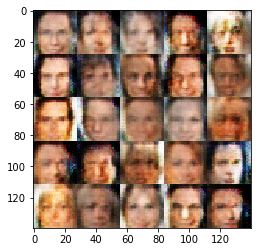

Epochs 1,batches 610, dis_loss 1.436286449432373 , gen_loss 0.6685342788696289
Epochs 1,batches 620, dis_loss 1.5366764068603516 , gen_loss 0.5829583406448364
Epochs 1,batches 630, dis_loss 1.4229166507720947 , gen_loss 0.8823977112770081
Epochs 1,batches 640, dis_loss 1.4765669107437134 , gen_loss 0.5092641115188599
Epochs 1,batches 650, dis_loss 1.315436601638794 , gen_loss 0.8471612334251404
Epochs 1,batches 660, dis_loss 1.5368974208831787 , gen_loss 0.4324040412902832
Epochs 1,batches 670, dis_loss 1.4991686344146729 , gen_loss 0.7306125164031982
Epochs 1,batches 680, dis_loss 1.4584977626800537 , gen_loss 0.9716464877128601
Epochs 1,batches 690, dis_loss 1.4565606117248535 , gen_loss 1.0875039100646973
Epochs 1,batches 700, dis_loss 1.417579174041748 , gen_loss 0.8141220808029175


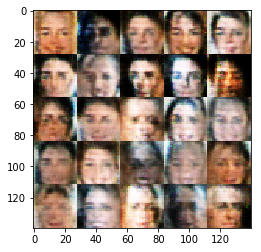

Epochs 1,batches 710, dis_loss 1.3773596286773682 , gen_loss 0.96201491355896
Epochs 1,batches 720, dis_loss 1.303067922592163 , gen_loss 0.6526937484741211
Epochs 1,batches 730, dis_loss 1.3622357845306396 , gen_loss 0.7747118473052979
Epochs 1,batches 740, dis_loss 1.2891473770141602 , gen_loss 0.9148522615432739
Epochs 1,batches 750, dis_loss 1.5475106239318848 , gen_loss 0.4603922963142395
Epochs 1,batches 760, dis_loss 1.4395520687103271 , gen_loss 1.1261179447174072
Epochs 1,batches 770, dis_loss 1.329704761505127 , gen_loss 0.809066891670227
Epochs 1,batches 780, dis_loss 1.5071446895599365 , gen_loss 0.8683055639266968
Epochs 1,batches 790, dis_loss 1.3134757280349731 , gen_loss 0.7706128358840942
Epochs 1,batches 800, dis_loss 1.5213866233825684 , gen_loss 0.5209341049194336


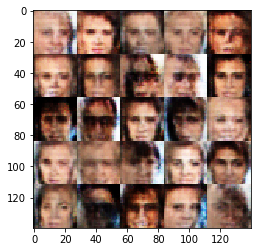

Epochs 1,batches 810, dis_loss 1.521797776222229 , gen_loss 0.5435504913330078
Epochs 1,batches 820, dis_loss 1.3244380950927734 , gen_loss 0.780774712562561
Epochs 1,batches 830, dis_loss 1.33427894115448 , gen_loss 0.806300163269043
Epochs 1,batches 840, dis_loss 1.384429693222046 , gen_loss 0.6978435516357422
Epochs 1,batches 850, dis_loss 1.3979647159576416 , gen_loss 0.8884155750274658
Epochs 1,batches 860, dis_loss 1.3509029150009155 , gen_loss 0.7561824321746826
Epochs 1,batches 870, dis_loss 1.3693573474884033 , gen_loss 0.5975084900856018
Epochs 1,batches 880, dis_loss 1.4419920444488525 , gen_loss 0.6688591837882996
Epochs 1,batches 890, dis_loss 1.3659332990646362 , gen_loss 0.9203311204910278
Epochs 1,batches 900, dis_loss 1.4087674617767334 , gen_loss 0.7215879559516907


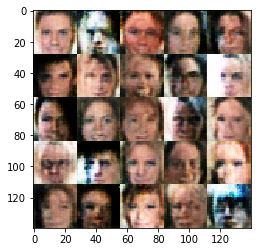

Epochs 1,batches 910, dis_loss 1.2803263664245605 , gen_loss 0.7132232785224915
Epochs 1,batches 920, dis_loss 1.4124970436096191 , gen_loss 0.8692202568054199
Epochs 1,batches 930, dis_loss 1.2932041883468628 , gen_loss 0.8833796977996826
Epochs 1,batches 940, dis_loss 1.3982093334197998 , gen_loss 0.9111518859863281
Epochs 1,batches 950, dis_loss 1.5166974067687988 , gen_loss 0.5760149359703064
Epochs 1,batches 960, dis_loss 1.4890644550323486 , gen_loss 0.6679040789604187
Epochs 1,batches 970, dis_loss 1.281923770904541 , gen_loss 0.9798133969306946
Epochs 1,batches 980, dis_loss 1.5179126262664795 , gen_loss 0.5543971657752991
Epochs 1,batches 990, dis_loss 1.3638191223144531 , gen_loss 0.7251222133636475
Epochs 1,batches 1000, dis_loss 1.4700437784194946 , gen_loss 0.6247110962867737


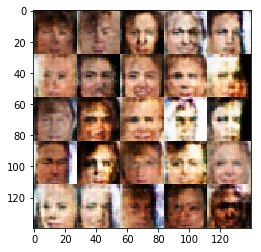

Epochs 1,batches 1010, dis_loss 1.5031598806381226 , gen_loss 0.5981451272964478
Epochs 1,batches 1020, dis_loss 1.408551812171936 , gen_loss 0.8209303617477417
Epochs 1,batches 1030, dis_loss 1.4869588613510132 , gen_loss 0.6561921834945679
Epochs 1,batches 1040, dis_loss 1.4228463172912598 , gen_loss 0.7174202799797058
Epochs 1,batches 1050, dis_loss 1.4456803798675537 , gen_loss 0.7731691598892212
Epochs 1,batches 1060, dis_loss 1.4189053773880005 , gen_loss 0.6392328143119812
Epochs 1,batches 1070, dis_loss 1.3724173307418823 , gen_loss 0.7664936780929565
Epochs 1,batches 1080, dis_loss 1.536672592163086 , gen_loss 0.8428152799606323
Epochs 1,batches 1090, dis_loss 1.3718798160552979 , gen_loss 0.9034334421157837
Epochs 1,batches 1100, dis_loss 1.3820068836212158 , gen_loss 0.7453188896179199


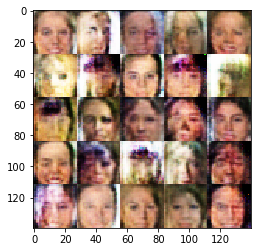

Epochs 1,batches 1110, dis_loss 1.3211908340454102 , gen_loss 0.9158686399459839
Epochs 1,batches 1120, dis_loss 1.4458980560302734 , gen_loss 1.2509135007858276
Epochs 1,batches 1130, dis_loss 1.3841335773468018 , gen_loss 0.5870466232299805
Epochs 1,batches 1140, dis_loss 1.4322593212127686 , gen_loss 0.6823256015777588
Epochs 1,batches 1150, dis_loss 1.477409839630127 , gen_loss 0.9971491098403931
Epochs 1,batches 1160, dis_loss 1.2470730543136597 , gen_loss 0.849890947341919
Epochs 1,batches 1170, dis_loss 1.4154635667800903 , gen_loss 0.6292352676391602
Epochs 1,batches 1180, dis_loss 1.313077688217163 , gen_loss 0.6921811103820801
Epochs 1,batches 1190, dis_loss 1.5226563215255737 , gen_loss 0.5047258138656616
Epochs 1,batches 1200, dis_loss 1.4022407531738281 , gen_loss 0.6934950351715088


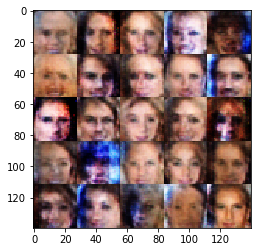

Epochs 1,batches 1210, dis_loss 1.467556357383728 , gen_loss 0.8405539989471436
Epochs 1,batches 1220, dis_loss 1.5216923952102661 , gen_loss 1.1175018548965454
Epochs 1,batches 1230, dis_loss 1.3909052610397339 , gen_loss 0.7154686450958252
Epochs 1,batches 1240, dis_loss 1.3954499959945679 , gen_loss 0.6707637906074524
Epochs 1,batches 1250, dis_loss 1.2799327373504639 , gen_loss 0.8968356847763062
Epochs 1,batches 1260, dis_loss 1.4264456033706665 , gen_loss 0.7355058193206787
Epochs 1,batches 1270, dis_loss 1.4498857259750366 , gen_loss 0.7693066596984863
Epochs 1,batches 1280, dis_loss 1.3573095798492432 , gen_loss 0.6997884511947632
Epochs 1,batches 1290, dis_loss 1.4219627380371094 , gen_loss 0.859731912612915
Epochs 1,batches 1300, dis_loss 1.4160821437835693 , gen_loss 0.844369113445282


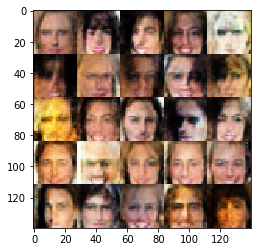

Epochs 1,batches 1310, dis_loss 1.431746482849121 , gen_loss 0.7835094928741455
Epochs 1,batches 1320, dis_loss 1.3726145029067993 , gen_loss 0.7262955904006958
Epochs 1,batches 1330, dis_loss 1.3078937530517578 , gen_loss 0.8416152596473694
Epochs 1,batches 1340, dis_loss 1.3555692434310913 , gen_loss 0.7308821082115173
Epochs 1,batches 1350, dis_loss 1.40401291847229 , gen_loss 0.6906790733337402
Epochs 1,batches 1360, dis_loss 1.362520694732666 , gen_loss 1.0126795768737793
Epochs 1,batches 1370, dis_loss 1.416153073310852 , gen_loss 0.8904462456703186
Epochs 1,batches 1380, dis_loss 1.3814129829406738 , gen_loss 0.7138335704803467
Epochs 1,batches 1390, dis_loss 1.4062752723693848 , gen_loss 0.8138713836669922
Epochs 1,batches 1400, dis_loss 1.4246374368667603 , gen_loss 0.8594861030578613


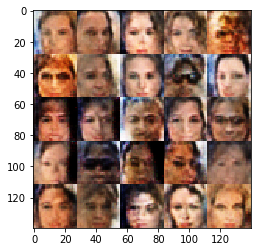

Epochs 1,batches 1410, dis_loss 1.4716252088546753 , gen_loss 0.6047533750534058
Epochs 1,batches 1420, dis_loss 1.4183111190795898 , gen_loss 0.7508837580680847
Epochs 1,batches 1430, dis_loss 1.3352361917495728 , gen_loss 0.7796869277954102
Epochs 1,batches 1440, dis_loss 1.374882698059082 , gen_loss 0.804117739200592
Epochs 1,batches 1450, dis_loss 1.44141685962677 , gen_loss 1.1474857330322266
Epochs 1,batches 1460, dis_loss 1.261836051940918 , gen_loss 0.8294787406921387
Epochs 1,batches 1470, dis_loss 1.4584851264953613 , gen_loss 0.5786316394805908
Epochs 1,batches 1480, dis_loss 1.3812053203582764 , gen_loss 0.7425240874290466
Epochs 1,batches 1490, dis_loss 1.3848235607147217 , gen_loss 0.9265010952949524
Epochs 1,batches 1500, dis_loss 1.423353910446167 , gen_loss 0.5748400688171387


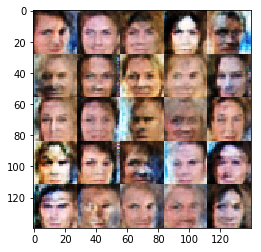

Epochs 1,batches 1510, dis_loss 1.3311450481414795 , gen_loss 0.894420325756073
Epochs 1,batches 1520, dis_loss 1.3473678827285767 , gen_loss 0.9259160161018372
Epochs 1,batches 1530, dis_loss 1.4265706539154053 , gen_loss 0.68944251537323
Epochs 1,batches 1540, dis_loss 1.3109734058380127 , gen_loss 0.8644796013832092
Epochs 1,batches 1550, dis_loss 1.3936402797698975 , gen_loss 0.6210647821426392
Epochs 1,batches 1560, dis_loss 1.3594940900802612 , gen_loss 0.8321049809455872
Epochs 1,batches 1570, dis_loss 1.4614531993865967 , gen_loss 0.8486665487289429
Epochs 1,batches 1580, dis_loss 1.3849375247955322 , gen_loss 0.8017600178718567
Epochs 1,batches 1590, dis_loss 1.427478313446045 , gen_loss 0.7443611025810242
Epochs 1,batches 1600, dis_loss 1.3277521133422852 , gen_loss 0.9842331409454346


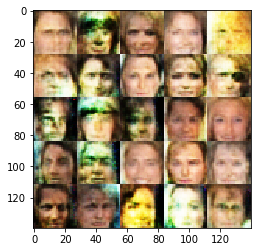

Epochs 1,batches 1610, dis_loss 1.3954033851623535 , gen_loss 0.8227100968360901
Epochs 1,batches 1620, dis_loss 1.3575741052627563 , gen_loss 0.7129428386688232
Epochs 1,batches 1630, dis_loss 1.3865300416946411 , gen_loss 0.6448354721069336
Epochs 1,batches 1640, dis_loss 1.4245582818984985 , gen_loss 0.6141182780265808
Epochs 1,batches 1650, dis_loss 1.3327196836471558 , gen_loss 0.7550321817398071
Epochs 1,batches 1660, dis_loss 1.4969279766082764 , gen_loss 0.8850293159484863
Epochs 1,batches 1670, dis_loss 1.4801210165023804 , gen_loss 0.6343345046043396
Epochs 1,batches 1680, dis_loss 1.3796591758728027 , gen_loss 0.8704272508621216
Epochs 1,batches 1690, dis_loss 1.3456400632858276 , gen_loss 0.6888563632965088
Epochs 1,batches 1700, dis_loss 1.4594391584396362 , gen_loss 0.9466452598571777


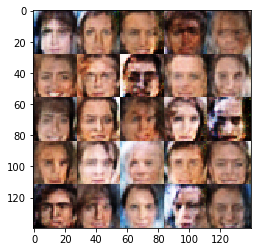

Epochs 1,batches 1710, dis_loss 1.4292300939559937 , gen_loss 0.8506905436515808
Epochs 1,batches 1720, dis_loss 1.4727884531021118 , gen_loss 0.5781176090240479
Epochs 1,batches 1730, dis_loss 1.400075912475586 , gen_loss 0.9803177118301392
Epochs 1,batches 1740, dis_loss 1.5036704540252686 , gen_loss 0.7554374933242798
Epochs 1,batches 1750, dis_loss 1.3897104263305664 , gen_loss 0.8366760015487671
Epochs 1,batches 1760, dis_loss 1.3875303268432617 , gen_loss 0.6955859661102295
Epochs 1,batches 1770, dis_loss 1.3970355987548828 , gen_loss 0.8791630864143372
Epochs 1,batches 1780, dis_loss 1.4671883583068848 , gen_loss 0.8204286694526672
Epochs 1,batches 1790, dis_loss 1.4802019596099854 , gen_loss 0.5886005759239197
Epochs 1,batches 1800, dis_loss 1.419780969619751 , gen_loss 0.786592960357666


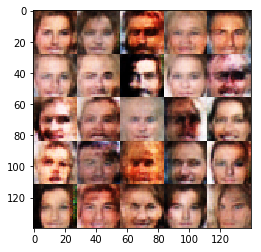

Epochs 1,batches 1810, dis_loss 1.421276330947876 , gen_loss 0.7143255472183228
Epochs 1,batches 1820, dis_loss 1.2617032527923584 , gen_loss 0.9741334319114685
Epochs 1,batches 1830, dis_loss 1.4217506647109985 , gen_loss 0.9175999164581299
Epochs 1,batches 1840, dis_loss 1.3276433944702148 , gen_loss 0.6844651103019714
Epochs 1,batches 1850, dis_loss 1.397613525390625 , gen_loss 0.6827558279037476
Epochs 1,batches 1860, dis_loss 1.3853771686553955 , gen_loss 0.7187390327453613
Epochs 1,batches 1870, dis_loss 1.4392268657684326 , gen_loss 0.6369640827178955
Epochs 1,batches 1880, dis_loss 1.5402052402496338 , gen_loss 0.49295294284820557
Epochs 1,batches 1890, dis_loss 1.4259519577026367 , gen_loss 0.712264895439148
Epochs 1,batches 1900, dis_loss 1.388077974319458 , gen_loss 0.8365475535392761


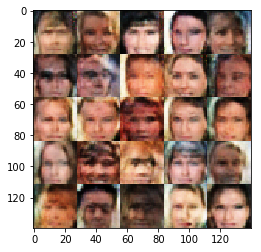

Epochs 1,batches 1910, dis_loss 1.4317691326141357 , gen_loss 0.7319545149803162
Epochs 1,batches 1920, dis_loss 1.434981346130371 , gen_loss 0.5765894651412964
Epochs 1,batches 1930, dis_loss 1.4289194345474243 , gen_loss 0.6568145751953125
Epochs 1,batches 1940, dis_loss 1.3687572479248047 , gen_loss 0.699263870716095
Epochs 1,batches 1950, dis_loss 1.3750195503234863 , gen_loss 0.7847903966903687
Epochs 1,batches 1960, dis_loss 1.4043413400650024 , gen_loss 1.0343178510665894
Epochs 1,batches 1970, dis_loss 1.42755925655365 , gen_loss 0.6528942584991455
Epochs 1,batches 1980, dis_loss 1.2683911323547363 , gen_loss 0.9050890803337097
Epochs 1,batches 1990, dis_loss 1.335218906402588 , gen_loss 0.8698196411132812
Epochs 1,batches 2000, dis_loss 1.3933167457580566 , gen_loss 0.7629780173301697


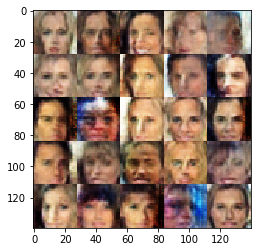

Epochs 1,batches 2010, dis_loss 1.4584789276123047 , gen_loss 0.6453600525856018
Epochs 1,batches 2020, dis_loss 1.3432037830352783 , gen_loss 0.7075415849685669
Epochs 1,batches 2030, dis_loss 1.4275121688842773 , gen_loss 0.7080858945846558
Epochs 1,batches 2040, dis_loss 1.386894941329956 , gen_loss 0.8675147891044617
Epochs 1,batches 2050, dis_loss 1.306386113166809 , gen_loss 1.0258647203445435
Epochs 1,batches 2060, dis_loss 1.4003431797027588 , gen_loss 0.8348487615585327
Epochs 1,batches 2070, dis_loss 1.3649107217788696 , gen_loss 0.8343368172645569
Epochs 1,batches 2080, dis_loss 1.4144141674041748 , gen_loss 1.044602394104004
Epochs 1,batches 2090, dis_loss 1.4287924766540527 , gen_loss 0.75093674659729
Epochs 1,batches 2100, dis_loss 1.4295179843902588 , gen_loss 0.7106471657752991


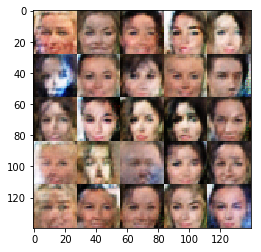

Epochs 1,batches 2110, dis_loss 1.3883044719696045 , gen_loss 0.7718096375465393
Epochs 1,batches 2120, dis_loss 1.3109159469604492 , gen_loss 0.9233471155166626
Epochs 1,batches 2130, dis_loss 1.392824411392212 , gen_loss 0.8462309837341309
Epochs 1,batches 2140, dis_loss 1.4149975776672363 , gen_loss 0.5516130328178406
Epochs 1,batches 2150, dis_loss 1.3679434061050415 , gen_loss 0.8321817517280579
Epochs 1,batches 2160, dis_loss 1.400446891784668 , gen_loss 0.7971458435058594
Epochs 1,batches 2170, dis_loss 1.3433226346969604 , gen_loss 0.7074968218803406
Epochs 1,batches 2180, dis_loss 1.4637991189956665 , gen_loss 0.7607311010360718
Epochs 1,batches 2190, dis_loss 1.4867761135101318 , gen_loss 0.5889577865600586
Epochs 1,batches 2200, dis_loss 1.3005003929138184 , gen_loss 0.8244731426239014


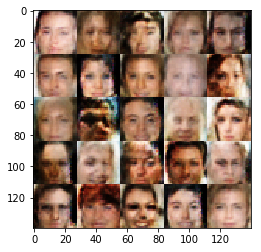

Epochs 1,batches 2210, dis_loss 1.3452527523040771 , gen_loss 0.9097813963890076
Epochs 1,batches 2220, dis_loss 1.3669774532318115 , gen_loss 0.6904438734054565
Epochs 1,batches 2230, dis_loss 1.380263090133667 , gen_loss 0.8188486099243164
Epochs 1,batches 2240, dis_loss 1.4488033056259155 , gen_loss 0.6725871562957764
Epochs 1,batches 2250, dis_loss 1.364912748336792 , gen_loss 0.7800423502922058
Epochs 1,batches 2260, dis_loss 1.4123756885528564 , gen_loss 0.5821913480758667
Epochs 1,batches 2270, dis_loss 1.337567687034607 , gen_loss 0.8121061325073242
Epochs 1,batches 2280, dis_loss 1.3524413108825684 , gen_loss 0.7554314136505127
Epochs 1,batches 2290, dis_loss 1.38368821144104 , gen_loss 0.8349684476852417
Epochs 1,batches 2300, dis_loss 1.2578027248382568 , gen_loss 0.9147330522537231


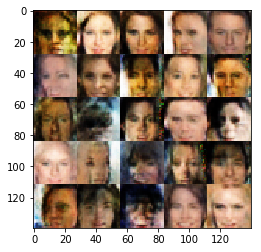

Epochs 1,batches 2310, dis_loss 1.3417543172836304 , gen_loss 0.7850049734115601
Epochs 1,batches 2320, dis_loss 1.4710958003997803 , gen_loss 0.7615311145782471
Epochs 1,batches 2330, dis_loss 1.4926762580871582 , gen_loss 1.0401540994644165
Epochs 1,batches 2340, dis_loss 1.4733402729034424 , gen_loss 0.756388783454895
Epochs 1,batches 2350, dis_loss 1.4543399810791016 , gen_loss 0.814342737197876
Epochs 1,batches 2360, dis_loss 1.3999305963516235 , gen_loss 0.734112024307251
Epochs 1,batches 2370, dis_loss 1.4707889556884766 , gen_loss 0.584490180015564
Epochs 1,batches 2380, dis_loss 1.416303038597107 , gen_loss 0.744600772857666
Epochs 1,batches 2390, dis_loss 1.3707064390182495 , gen_loss 0.7776587009429932
Epochs 1,batches 2400, dis_loss 1.3456305265426636 , gen_loss 0.8158161640167236


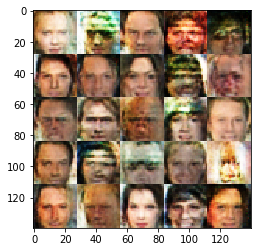

Epochs 1,batches 2410, dis_loss 1.5029408931732178 , gen_loss 1.141088604927063
Epochs 1,batches 2420, dis_loss 1.3680436611175537 , gen_loss 0.655799388885498
Epochs 1,batches 2430, dis_loss 1.3629258871078491 , gen_loss 0.8981031179428101
Epochs 1,batches 2440, dis_loss 1.3853871822357178 , gen_loss 0.8185281753540039
Epochs 1,batches 2450, dis_loss 1.3976221084594727 , gen_loss 0.6818042397499084
Epochs 1,batches 2460, dis_loss 1.3358440399169922 , gen_loss 0.7287077903747559
Epochs 1,batches 2470, dis_loss 1.3649375438690186 , gen_loss 0.680059552192688
Epochs 1,batches 2480, dis_loss 1.3467011451721191 , gen_loss 0.9635720252990723
Epochs 1,batches 2490, dis_loss 1.391676902770996 , gen_loss 0.7699374556541443
Epochs 1,batches 2500, dis_loss 1.3314054012298584 , gen_loss 0.7876010537147522


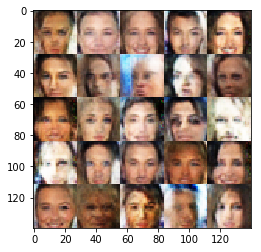

Epochs 1,batches 2510, dis_loss 1.358234167098999 , gen_loss 0.8072378635406494
Epochs 1,batches 2520, dis_loss 1.4515810012817383 , gen_loss 0.9654495716094971
Epochs 1,batches 2530, dis_loss 1.3450223207473755 , gen_loss 0.7892359495162964
Epochs 1,batches 2540, dis_loss 1.370665431022644 , gen_loss 0.8414093852043152
Epochs 1,batches 2550, dis_loss 1.3821407556533813 , gen_loss 0.9414191246032715
Epochs 1,batches 2560, dis_loss 1.3819446563720703 , gen_loss 0.691819965839386
Epochs 1,batches 2570, dis_loss 1.36033034324646 , gen_loss 0.8941975235939026
Epochs 1,batches 2580, dis_loss 1.3738069534301758 , gen_loss 0.692300021648407
Epochs 1,batches 2590, dis_loss 1.4077537059783936 , gen_loss 0.6641451120376587
Epochs 1,batches 2600, dis_loss 1.4219127893447876 , gen_loss 0.6294080018997192


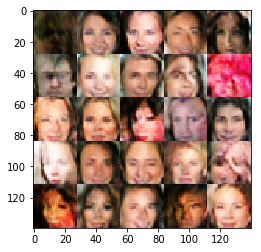

Epochs 1,batches 2610, dis_loss 1.2983267307281494 , gen_loss 0.6928146481513977
Epochs 1,batches 2620, dis_loss 1.3202441930770874 , gen_loss 0.8367303013801575
Epochs 1,batches 2630, dis_loss 1.3869082927703857 , gen_loss 0.7010718584060669
Epochs 1,batches 2640, dis_loss 1.4918640851974487 , gen_loss 0.8035305738449097
Epochs 1,batches 2650, dis_loss 1.3868680000305176 , gen_loss 0.8071154952049255
Epochs 1,batches 2660, dis_loss 1.4217004776000977 , gen_loss 0.82844078540802
Epochs 1,batches 2670, dis_loss 1.4081101417541504 , gen_loss 0.7959489822387695
Epochs 1,batches 2680, dis_loss 1.2894275188446045 , gen_loss 0.9006316065788269
Epochs 1,batches 2690, dis_loss 1.3794184923171997 , gen_loss 0.8358852863311768
Epochs 1,batches 2700, dis_loss 1.3819496631622314 , gen_loss 0.7175338268280029


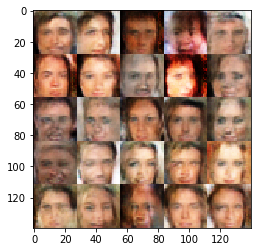

Epochs 1,batches 2710, dis_loss 1.318807601928711 , gen_loss 0.8569609522819519
Epochs 1,batches 2720, dis_loss 1.4131028652191162 , gen_loss 0.6376980543136597
Epochs 1,batches 2730, dis_loss 1.3745003938674927 , gen_loss 0.7380368709564209
Epochs 1,batches 2740, dis_loss 1.3538546562194824 , gen_loss 0.6479604244232178
Epochs 1,batches 2750, dis_loss 1.3637669086456299 , gen_loss 0.765163004398346
Epochs 1,batches 2760, dis_loss 1.3774354457855225 , gen_loss 0.819229006767273
Epochs 1,batches 2770, dis_loss 1.4301533699035645 , gen_loss 0.5754798650741577
Epochs 1,batches 2780, dis_loss 1.4494943618774414 , gen_loss 0.5868784785270691
Epochs 1,batches 2790, dis_loss 1.3754500150680542 , gen_loss 0.8692847490310669
Epochs 1,batches 2800, dis_loss 1.3484978675842285 , gen_loss 0.9141280651092529


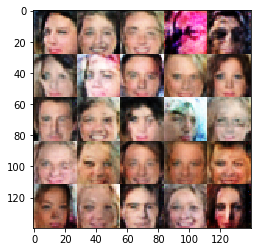

Epochs 1,batches 2810, dis_loss 1.3964070081710815 , gen_loss 0.7905807495117188
Epochs 1,batches 2820, dis_loss 1.3876326084136963 , gen_loss 0.7580556273460388
Epochs 1,batches 2830, dis_loss 1.337456226348877 , gen_loss 0.8350406289100647
Epochs 1,batches 2840, dis_loss 1.354665994644165 , gen_loss 0.8245197534561157
Epochs 1,batches 2850, dis_loss 1.3968003988265991 , gen_loss 1.1044398546218872
Epochs 1,batches 2860, dis_loss 1.3477147817611694 , gen_loss 0.9253777265548706
Epochs 1,batches 2870, dis_loss 1.3715177774429321 , gen_loss 0.7775185108184814
Epochs 1,batches 2880, dis_loss 1.4094055891036987 , gen_loss 0.7547599077224731
Epochs 1,batches 2890, dis_loss 1.3380467891693115 , gen_loss 0.7714776992797852
Epochs 1,batches 2900, dis_loss 1.4210708141326904 , gen_loss 0.577232837677002


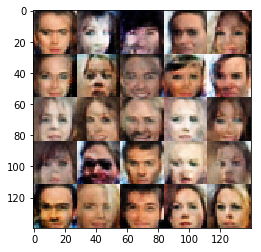

Epochs 1,batches 2910, dis_loss 1.3792977333068848 , gen_loss 0.6637465953826904
Epochs 1,batches 2920, dis_loss 1.3675204515457153 , gen_loss 0.9721536040306091
Epochs 1,batches 2930, dis_loss 1.3640691041946411 , gen_loss 0.7630203366279602
Epochs 1,batches 2940, dis_loss 1.3778431415557861 , gen_loss 0.7621563673019409
Epochs 1,batches 2950, dis_loss 1.3494343757629395 , gen_loss 0.8877305388450623
Epochs 1,batches 2960, dis_loss 1.35946786403656 , gen_loss 0.9486165046691895
Epochs 1,batches 2970, dis_loss 1.3503375053405762 , gen_loss 0.9353252649307251
Epochs 1,batches 2980, dis_loss 1.399444818496704 , gen_loss 0.9584712386131287
Epochs 1,batches 2990, dis_loss 1.3630667924880981 , gen_loss 0.7737495303153992
Epochs 1,batches 3000, dis_loss 1.329184651374817 , gen_loss 0.742616593837738


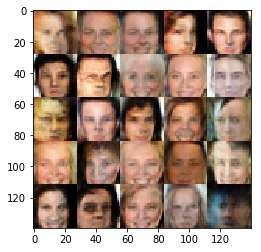

Epochs 1,batches 3010, dis_loss 1.3448092937469482 , gen_loss 0.908440351486206
Epochs 1,batches 3020, dis_loss 1.4379132986068726 , gen_loss 0.5574872493743896
Epochs 1,batches 3030, dis_loss 1.377807855606079 , gen_loss 0.8485908508300781
Epochs 1,batches 3040, dis_loss 1.3759748935699463 , gen_loss 0.8461092710494995
Epochs 1,batches 3050, dis_loss 1.3381702899932861 , gen_loss 0.8094744086265564
Epochs 1,batches 3060, dis_loss 1.411329984664917 , gen_loss 0.7064663171768188
Epochs 1,batches 3070, dis_loss 1.3702436685562134 , gen_loss 0.7802238464355469
Epochs 1,batches 3080, dis_loss 1.3245666027069092 , gen_loss 0.7574270963668823
Epochs 1,batches 3090, dis_loss 1.349225640296936 , gen_loss 0.8267701268196106
Epochs 1,batches 3100, dis_loss 1.4248335361480713 , gen_loss 0.6673885583877563


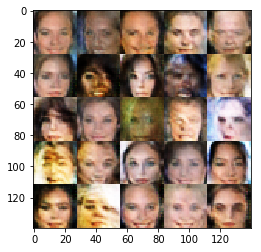

Epochs 1,batches 3110, dis_loss 1.391800045967102 , gen_loss 0.6369298696517944
Epochs 1,batches 3120, dis_loss 1.3315643072128296 , gen_loss 0.800163984298706
Epochs 1,batches 3130, dis_loss 1.3515360355377197 , gen_loss 0.8586199283599854
Epochs 1,batches 3140, dis_loss 1.370532512664795 , gen_loss 0.8611391186714172
Epochs 1,batches 3150, dis_loss 1.44667649269104 , gen_loss 0.6128487586975098
Epochs 1,batches 3160, dis_loss 1.4215315580368042 , gen_loss 0.5916904211044312


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.